# Desafio técnico

In [10]:
# !pip install unrar lazypredict optuna patool

In [9]:
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import patoolib, unrar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, confusion_matrix, log_loss, f1_score, roc_auc_score, roc_curve
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgbm
import optuna
import xgboost as xgb

Download e gerenciamento da base de dados

In [ ]:
# Baixando o arquivo
if not Path().cwd().parent.joinpath('data/cancellation_prediction.rar').is_file():
    !wget https://dhauz-challenges.s3.amazonaws.com/cancellation_prediction.rar
    # Movendo arquivo para pasta 'data'
    !mv cancellation_prediction.rar -t  ../data
file_dir = Path().cwd().parent/'data'
file = file_dir/'cancellation_prediction.rar'
csv_path = file_dir.joinpath('cancellation_prediction.csv')
# Descompatando arquivo
if not csv_path.is_file():
    try:
        patoolib.extract_archive(file, outdir=file_dir)
    except Exception as e:
        print(f'Error: {e}')

### Importando dados

In [ ]:
# DataFrame com a base de dados
csv = pd.read_csv(csv_path)

### Análise inicial e limpeza dos dados nulos/duplicados

In [ ]:
# Dimensões do arquivo
print(f'Linhas: {csv.shape[0]}')
print(f'Colunas: {csv.shape[1]}')

Linhas: 119390
Colunas: 28


In [ ]:
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   type                             119390 non-null  object 
 1   cancellation                     119390 non-null  int64  
 2   days_between_booking_arrival     119390 non-null  int64  
 3   year_arrival_date                119390 non-null  int64  
 4   month_arrival_date               119390 non-null  object 
 5   week_number_arrival_date         119390 non-null  int64  
 6   day_of_month_arrival_date        119390 non-null  int64  
 7   num_weekend_nights               119390 non-null  int64  
 8   num_workweek_nights              119390 non-null  int64  
 9   num_adults                       119390 non-null  int64  
 10  num_children                     119386 non-null  float64
 11  num_babies                       119390 non-null  int64  
 12  br

In [ ]:
# Distribuição de variáveis numéricas
csv.describe().T

count    mean    std     min     25%  \
cancellation                    119390.00    0.37   0.48    0.00    0.00   
days_between_booking_arrival    119390.00  104.01 106.86    0.00   18.00   
year_arrival_date               119390.00 2016.16   0.71 2015.00 2016.00   
week_number_arrival_date        119390.00   27.17  13.61    1.00   16.00   
day_of_month_arrival_date       119390.00   15.80   8.78    1.00    8.00   
num_weekend_nights              119390.00    0.93   1.00    0.00    0.00   
num_workweek_nights             119390.00    2.50   1.91    0.00    1.00   
num_adults                      119390.00    1.86   0.58    0.00    2.00   
num_children                    119386.00    0.10   0.40    0.00    0.00   
num_babies                      119390.00    0.01   0.10    0.00    0.00   
market_segment                  119390.00    2.47   1.42    0.00    2.00   
distribution_channel            119390.00    1.70   0.68    0.00    2.00   
repeated_guest                  119390.00    0.03   0.18    0.00    0.00   
num_previous_cancellations      119390.00    0.09   0.84    0.00    0.00   
num_previous_stays              119390.00    0.14   1.50    0.00    0.00   
changes_between_booking_arrival 119390.00    0.22   0.65    0.00    0.00   
id_travel_agency_booking        103050.00   86.69 110.77    1.00    9.00   
id_person_booking                 6797.00  189.27 131.66    6.00   62.00   
customer_type                   119390.00    0.47   0.84    0.00    0.00   
avg_price                       119390.00  101.72  47.82    0.00   69.29   
required_car_parking_spaces     119390.00    0.06   0.25    0.00    0.00   
total_of_special_requests       119390.00    0.57   0.79    0.00    0.00   

                                    50%     75%     max  
cancellation                       0.00    1.00    1.00  
days_between_booking_arrival      69.00  160.00  737.00  
year_arrival_date               2016.00 2017.00 2017.00  
week_number_arrival_date          28.00   38.00   53.00  
day_of_month_arrival_date         16.00   23.00   31.00  
num_weekend_nights                 1.00    2.00   19.00  
num_workweek_nights                2.00    3.00   50.00  
num_adults                         2.00    2.00   55.00  
num_children                       0.00    0.00   10.00  
num_babies                         0.00    0.00   10.00  
market_segment                     2.00    3.00    7.00  
distribution_channel               2.00    2.00    4.00  
repeated_guest                     0.00    0.00    1.00  
num_previous_cancellations         0.00    0.00   26.00  
num_previous_stays                 0.00    0.00   72.00  
changes_between_booking_arrival    0.00    0.00   21.00  
id_travel_agency_booking          14.00  229.00  535.00  
id_person_booking                179.00  270.00  543.00  
customer_type                      0.00    0.00    3.00  
avg_price                         94.58  126.00  300.00  
required_car_parking_spaces        0.00    0.00    8.00  
total_of_special_requests          0.00    1.00    5.00

In [ ]:
# Criando uma cópia para não trabalhar na base dados inicial
df = csv.copy()

In [ ]:
# Verificação de dados nulos
cols_with_nulls = [(col, df[col].isnull().sum()) for col in df.columns if df[col].isnull().sum() != 0]
print(f'Número de dados nulos por coluna: {cols_with_nulls}')

Número de dados nulos por coluna: [('num_children', 4), ('country', 488), ('id_travel_agency_booking', 16340), ('id_person_booking', 112593)]


In [ ]:
# Calculando a porcentagem de dados nulos por coluna
for col in list(zip(*cols_with_nulls))[0]:
    print(f"Porcentagem de dados nulos na coluna '{col}': {(df[col].isnull().sum()/df.shape[0]) * 100:.2f}%")

Porcentagem de dados nulos na coluna 'num_children': 0.00%
Porcentagem de dados nulos na coluna 'country': 0.41%
Porcentagem de dados nulos na coluna 'id_travel_agency_booking': 13.69%
Porcentagem de dados nulos na coluna 'id_person_booking': 94.31%


In [ ]:
# Devido a grande quantidade de dados nulos, a coluna 'id_person_booking' foi removida
df = df.drop('id_person_booking', axis=1)

In [ ]:
# Analisando a coluna 'id_travel_agency_booking', pois possui uma quantidade considerável de dados nulos.
# porém não é viável excluí-la nem excluir as linhas com valores nulos, pois a perda de informações seria grande.
id_travel_freq = df['id_travel_agency_booking'].value_counts()
id_travel_median = id_travel_freq.median()
id_travel_mode = id_travel_freq.mode().values

print(f"Mediana: \n{id_travel_freq[id_travel_freq == id_travel_median]}")
print(f"Moda: \n{id_travel_freq[id_travel_freq.values == id_travel_mode]}")

Mediana: 
id_travel_agency_booking
187.00    24
257.00    24
256.00    24
502.00    24
Name: count, dtype: int64
Moda: 
id_travel_agency_booking
453.00    1
114.00    1
346.00    1
406.00    1
367.00    1
480.00    1
352.00    1
300.00    1
301.00    1
397.00    1
388.00    1
416.00    1
446.00    1
299.00    1
333.00    1
73.00     1
472.00    1
444.00    1
408.00    1
291.00    1
483.00    1
197.00    1
433.00    1
431.00    1
213.00    1
54.00     1
70.00     1
497.00    1
337.00    1
90.00     1
165.00    1
117.00    1
358.00    1
158.00    1
144.00    1
451.00    1
216.00    1
294.00    1
59.00     1
267.00    1
450.00    1
247.00    1
278.00    1
280.00    1
285.00    1
289.00    1
432.00    1
265.00    1
93.00     1
304.00    1
Name: count, dtype: int64


In [ ]:
# Opto por preencher os valores nulos distribuindo entre os id's que aparecem apenas 1 vez no banco de dados.
id_travel_null_idx = df['id_travel_agency_booking'][df['id_travel_agency_booking'].isna()].index.tolist()
id_travel_mode_idx = id_travel_freq[id_travel_freq.values == id_travel_mode].index.tolist()

In [ ]:
def gerador(iterator, size):
    for n in range(0, len(iterator), size):
        yield iterator[n:n+size]

In [ ]:
gerador = gerador(id_travel_null_idx,len(id_travel_mode_idx))

In [ ]:
for index in gerador:
    map = dict(zip(index, id_travel_mode_idx))
    df['id_travel_agency_booking'].iloc[id_travel_null_idx] = df['id_travel_agency_booking'].iloc[id_travel_null_idx].fillna(map)
print(df['id_travel_agency_booking'].iloc[id_travel_null_idx])

0        453.00
1        114.00
2        346.00
6        406.00
18       367.00
          ...  
119124   451.00
119151   216.00
119166   294.00
119215    59.00
119248   267.00
Name: id_travel_agency_booking, Length: 16340, dtype: float64


In [ ]:
# Nova distribuição entre os id's
df['id_travel_agency_booking'].iloc[id_travel_null_idx].value_counts()

id_travel_agency_booking
453.00    327
197.00    327
431.00    327
213.00    327
114.00    327
70.00     327
497.00    327
337.00    327
90.00     327
165.00    327
117.00    327
358.00    327
158.00    327
144.00    327
451.00    327
216.00    327
294.00    327
59.00     327
267.00    327
433.00    327
54.00     327
483.00    327
388.00    327
346.00    327
406.00    327
367.00    327
480.00    327
291.00    327
300.00    327
301.00    327
397.00    327
352.00    327
416.00    327
299.00    327
333.00    327
73.00     327
472.00    327
444.00    327
408.00    327
446.00    327
289.00    326
93.00     326
265.00    326
432.00    326
247.00    326
285.00    326
280.00    326
278.00    326
450.00    326
304.00    326
Name: count, dtype: int64

In [ ]:
df['id_travel_agency_booking'].isna().sum()

0

In [ ]:
# Removendo as linhas com dados nulos das demais colunas
df = df.dropna()
df.shape

(118898, 27)

In [ ]:
# Verificação de dados duplicados
n_duplicates = df.duplicated().sum()
print(f'Número de linhas com dados duplicados: {n_duplicates}')

Número de linhas com dados duplicados: 29191


In [ ]:
# Removendo dados duplicados
df = df.drop_duplicates()
df.shape

(89707, 27)

### Feature Engineering

In [ ]:
# Visualizar e identificar possíveis variáveis binárias/discretizadas
for col in df.columns:
    if df[col].dtype not in ['object', 'bool']:
        print(f'Valores da coluna [{col}]:\n{df[col].value_counts()}')
        print(f'Tipo da variável: {df[col].dtype}')
        print('='*25, '\n')

Valores da coluna [cancellation]:
cancellation
0    63831
1    25876
Name: count, dtype: int64
Tipo da variável: int64

Valores da coluna [days_between_booking_arrival]:
days_between_booking_arrival
0      6011
1      3215
2      1922
3      1720
4      1584
       ... 
371       1
532       1
605       1
626       1
463       1
Name: count, Length: 479, dtype: int64
Tipo da variável: int64

Valores da coluna [year_arrival_date]:
year_arrival_date
2016    43053
2017    33094
2015    13560
Name: count, dtype: int64
Tipo da variável: int64

Valores da coluna [week_number_arrival_date]:
week_number_arrival_date
33    2785
34    2521
32    2471
28    2389
30    2365
31    2276
29    2213
27    2175
21    2143
18    2116
35    2113
15    2019
20    1997
23    1936
17    1915
25    1860
14    1850
13    1849
19    1848
22    1840
24    1819
26    1787
43    1760
16    1758
11    1737
7     1719
38    1693
8     1693
9     1658
10    1648
41    1625
36    1614
12    1580
39    1549
44    1543

Categorizando 'days_between_booking_arrival'

In [ ]:
df_cat = pd.DataFrame()

In [ ]:
def cat_dbba(x):
    if x <= 100: return 'under 100'
    if x > 100 and x <= 200: return 'between 100 and 200'
    else: return 'over 200'
df_cat['cat_days_between_booking_arrival'] = df['days_between_booking_arrival'].apply(cat_dbba)
df_cat['cat_days_between_booking_arrival'].value_counts()

cat_days_between_booking_arrival
under 100              61255
between 100 and 200    18924
over 200                9528
Name: count, dtype: int64

Categorizando 'num_previous_cancellations'

In [ ]:
def cat_npc(x):
    if x == 0: return 'None'
    if x > 0: return '1 or more'
df_cat['cat_num_previous_cancellations']=df['num_previous_cancellations'].apply(cat_npc)
df_cat['cat_num_previous_cancellations'].value_counts()

cat_num_previous_cancellations
None         87821
1 or more     1886
Name: count, dtype: int64

Categorizando 'num_previous_stays'

In [ ]:
def cat_nps(x):
    if x == 0: return 'None'
    if x > 0: return '1 or more'
df_cat['cat_num_previous_stays']=df['num_previous_stays'].apply(cat_nps)
df_cat['cat_num_previous_stays'].value_counts()

cat_num_previous_stays
None         86346
1 or more     3361
Name: count, dtype: int64

Categorizando 'changes_between_booking_arrival'

In [ ]:
def cat_cbba(x):
    if x == 0: return 'None'
    if x > 0: return '1 or more'
df_cat['cat_changes_between_booking_arrival'] = df['changes_between_booking_arrival'].apply(cat_cbba)
df_cat['cat_changes_between_booking_arrival'].value_counts()

cat_changes_between_booking_arrival
None         73651
1 or more    16056
Name: count, dtype: int64

Categorizando 'id_travel_agency_booking'

In [ ]:
def cat_itab(x):
    if x == 9.0: return 'Ag. 9'
    if x == 240.0: return 'Ag. 240'
    if x == 14.0: return 'Ag. 14'
    if x == 7.0: return 'Ag. 7'
    else: return 'Other'
df_cat['cat_id_travel_agency_booking'] = df['id_travel_agency_booking'].apply(cat_itab)
df_cat['cat_id_travel_agency_booking'].value_counts()

cat_id_travel_agency_booking
Other      41539
Ag. 9      28622
Ag. 240    12925
Ag. 14      3334
Ag. 7       3287
Name: count, dtype: int64

Categorizando 'avg_price'

In [ ]:
def cat_avg_price(x):
    if x < 50: return 'Less than 50'
    if x >= 50 and x < 100: return 'Between 50 and 100'
    if x >= 100 and x < 150: return 'Between 100 and 150'
    if x >= 150 and x < 200: return 'Between 150 and 200'
    if x >= 200 and x < 250: return 'Between 200 and 250'
    else: return 'Between 250 and 300'
df_cat['cat_avg_price']=df['avg_price'].apply(cat_avg_price)
df_cat['cat_avg_price'].value_counts()

cat_avg_price
Between 50 and 100     36749
Between 100 and 150    27436
Between 150 and 200    10722
Less than 50            9902
Between 200 and 250     3592
Between 250 and 300     1306
Name: count, dtype: int64

Categorizando 'cat_required_car_parking_spaces'

In [ ]:
def cat_rcps(x):
    if x == 0: return 'None'
    else: return '1 or more'
df_cat['cat_required_car_parking_spaces'] = df['required_car_parking_spaces'].apply(cat_rcps)
df_cat['cat_required_car_parking_spaces'].value_counts()

cat_required_car_parking_spaces
None         82445
1 or more     7262
Name: count, dtype: int64

##### Criando a variável 'arrival_season' que repesenta as estações do ano.

In [ ]:
def seasons(month):
    if month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Autumn'
    else:
        return 'Winter'

In [ ]:
df_cat['arrival_season'] = df['month_arrival_date'].apply(seasons)
df_cat['arrival_season'].value_counts()

arrival_season
Summer    29442
Spring    24678
Autumn    19023
Winter    16564
Name: count, dtype: int64

##### Criando as variaveis 'num_people', 'num_kids', 'total_nights'

In [ ]:
df_cat['num_people'] = df['num_adults'] + df['num_babies'] + df['num_children']
df_cat['num_kids'] = df['num_children'] + df['num_babies']
df_cat['total_nights'] = df['num_workweek_nights'] + df['num_weekend_nights']

Categorizando 'num_people'

In [ ]:
def cat_np(x):
    if x == 1.0: return '1'
    if x == 2.0: return '2'
    if x == 3.0: return '3'
    else: return '4 or more'
df_cat['num_people'] = df_cat['num_people'].apply(cat_np)
df_cat['num_people'].value_counts()

num_people
2            58493
1            16986
3            10048
4 or more     4180
Name: count, dtype: int64

Categorizando 'num_kids'

In [ ]:
def cat_nk(x):
    if x == 0.: return '0'
    if x == 1.: return '1'
    else: return '2 or more'
df_cat['num_kids'] = df_cat['num_kids'].apply(cat_nk)
df_cat['num_kids'].value_counts()

num_kids
0            80625
1             5264
2 or more     3818
Name: count, dtype: int64

Categorizando 'total_nights'

In [ ]:
def cat_tn(x):
    if x < 5: return 'Less then 5'
    if x >= 5 and x < 10: return 'Between 5 and 10'
    else: return '10 or more'
df_cat['total_nights'] = df_cat['total_nights'].apply(cat_tn)
df_cat['total_nights'].value_counts()

total_nights
Less then 5         67060
Between 5 and 10    19633
10 or more           3014
Name: count, dtype: int64

## Análise Exploratória de Dados (EDA)

Serão feitas visualizações para as variáveis inalteradas, assim como para as novas variáveis. Dessa forma, é possível analisar a mesma informação de diferentes formas, ajudando na formulação de hipóteses.

In [ ]:
# Separando as variáveis categóricas em 'df'
cat_cols = [col for col in df.columns if df[col].dtype in ['object','bool'] and col not in ['num_kids', 'num_people']]
for col in df.columns:
    if col in ['cancellation', 'repeated_guest', "distribution_channel", "customer_type", "market_segment"]:
        cat_cols.append(col)
print(cat_cols)
# Separando as variáveis numéricas
num_cols = [col for col in df.columns if col not in cat_cols]
print(num_cols)

['type', 'month_arrival_date', 'breakfast', 'country', 'reserved_room', 'deposit_policy', 'cancellation', 'market_segment', 'distribution_channel', 'repeated_guest', 'customer_type']
['days_between_booking_arrival', 'year_arrival_date', 'week_number_arrival_date', 'day_of_month_arrival_date', 'num_weekend_nights', 'num_workweek_nights', 'num_adults', 'num_children', 'num_babies', 'num_previous_cancellations', 'num_previous_stays', 'changes_between_booking_arrival', 'id_travel_agency_booking', 'avg_price', 'required_car_parking_spaces', 'total_of_special_requests']


### Análise Univariada

##### Dados numéricos

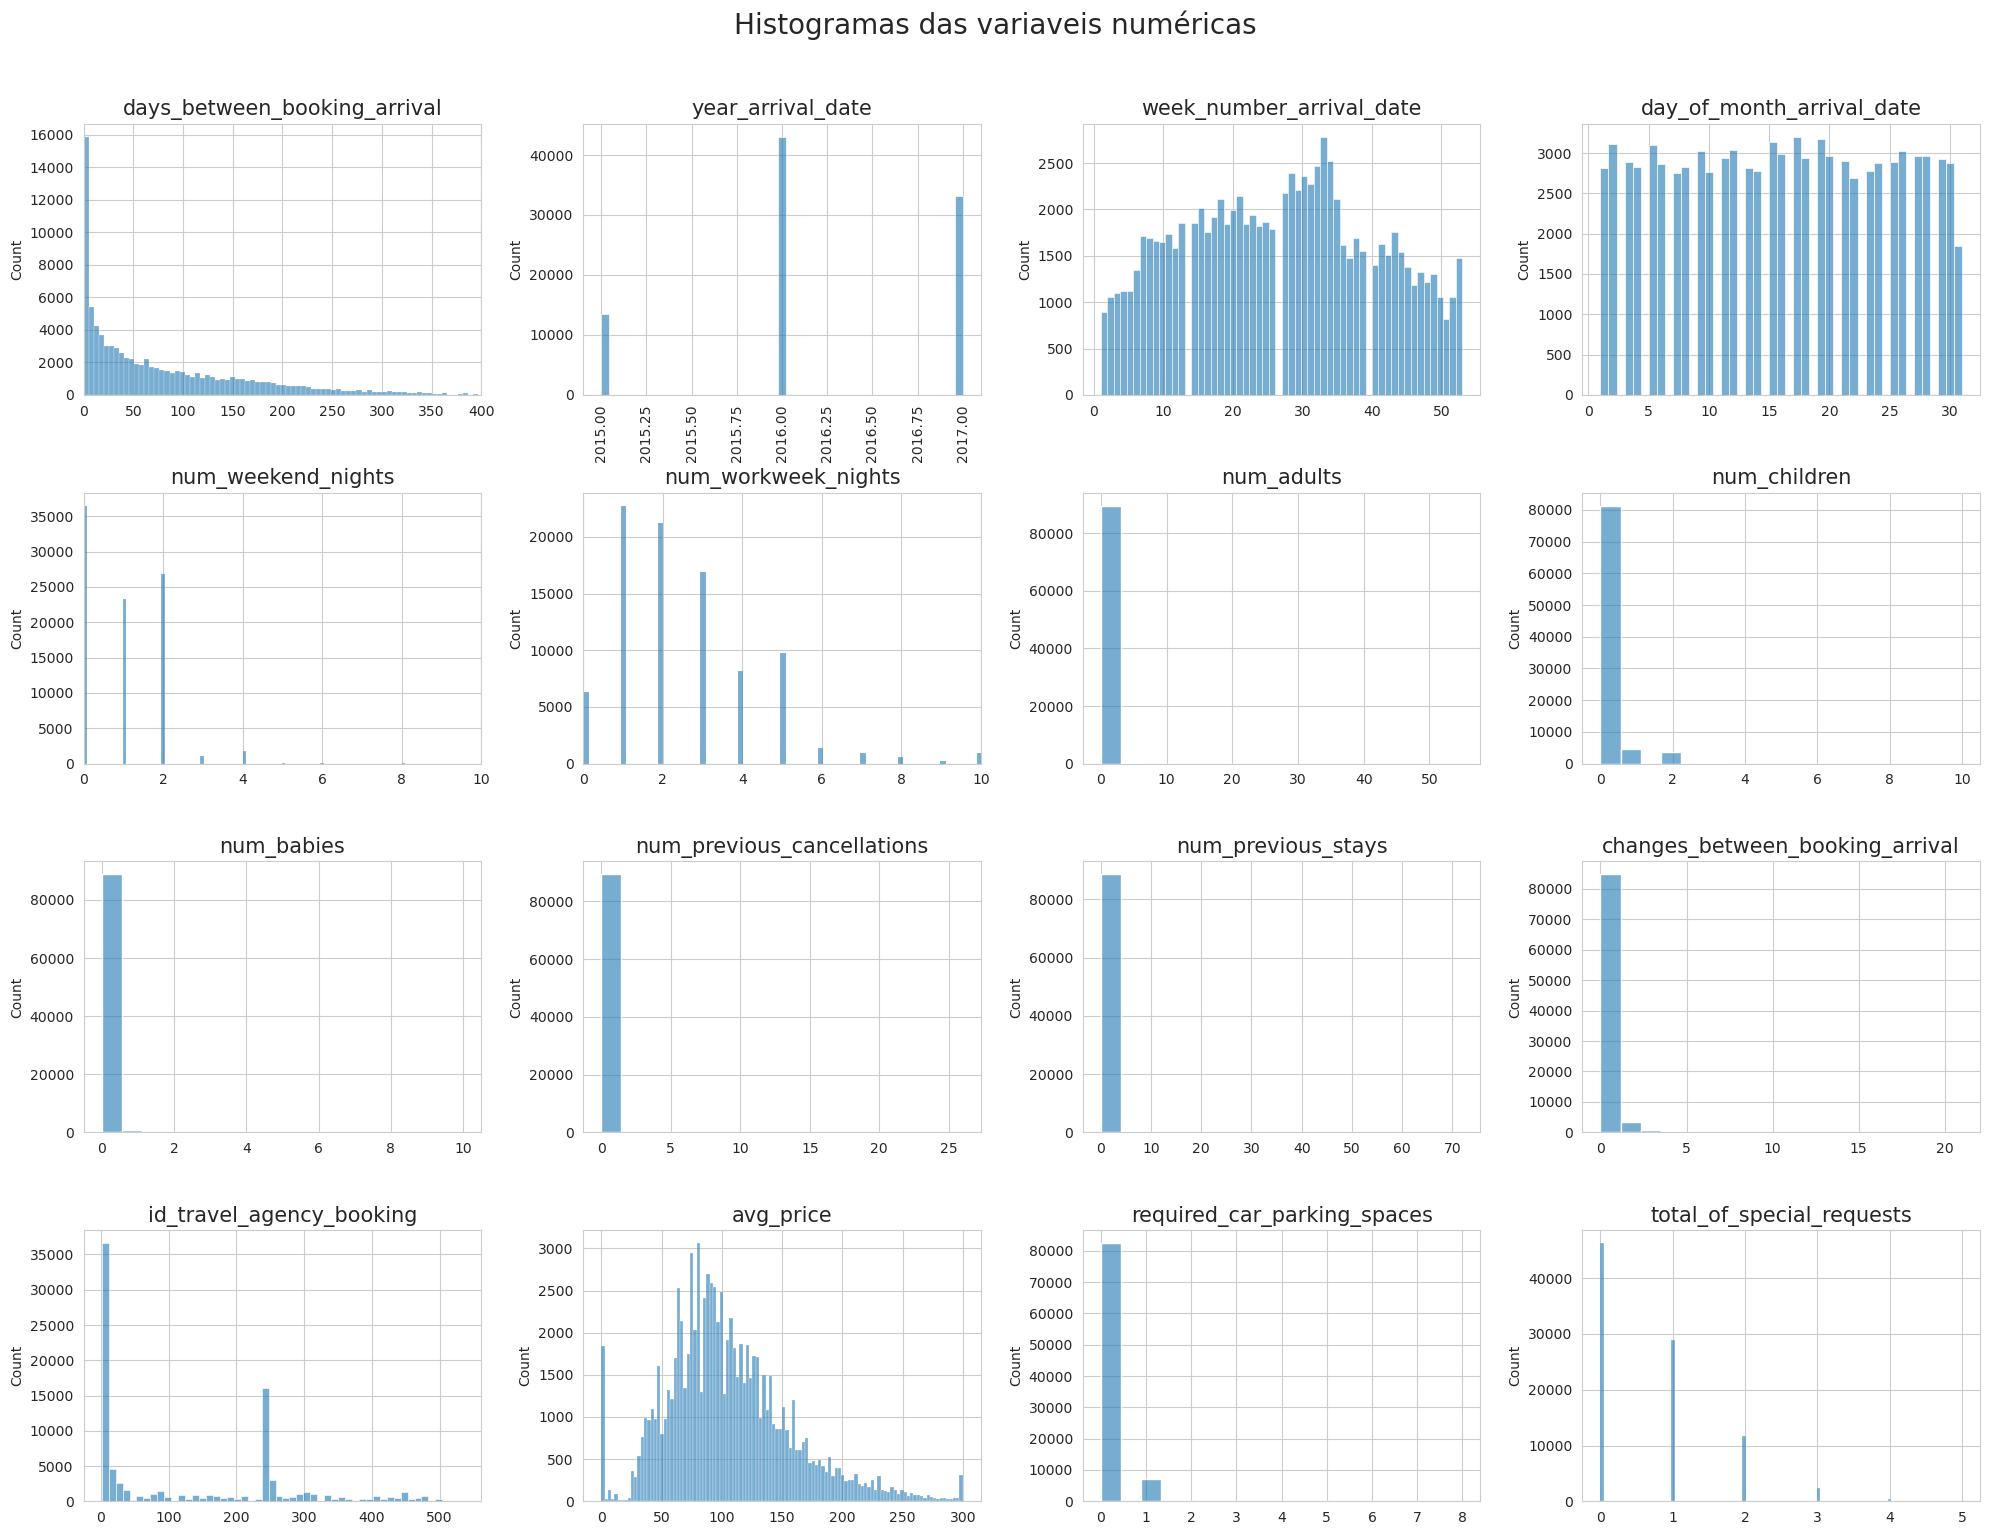

In [ ]:
# Histogramas das variáveis numéricas iniciais.
nrows=4
ncols=4
fig, axes = plt.subplots(nrows, ncols, figsize=(20,15))
for i, col in enumerate(num_cols):
    nrow = i // ncols
    ncol = i % ncols
    g = sns.histplot(df, x=num_cols[i], ax=axes[nrow,ncol], log_scale=False, alpha=.6)
    g.set_title(col, fontdict={'size': 15}, y=1)
    g.set_xlabel('')
    if col in ['year_arrival_date']:
        g.tick_params(axis='x', labelrotation=90)
    if col == 'days_between_booking_arrival':
        g.set_xlim(0, 400)
    if col in ['num_workweek_nights','num_weekend_nights']:
        g.set_xlim(0, 10)
fig.suptitle('Histogramas das variaveis numéricas', y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

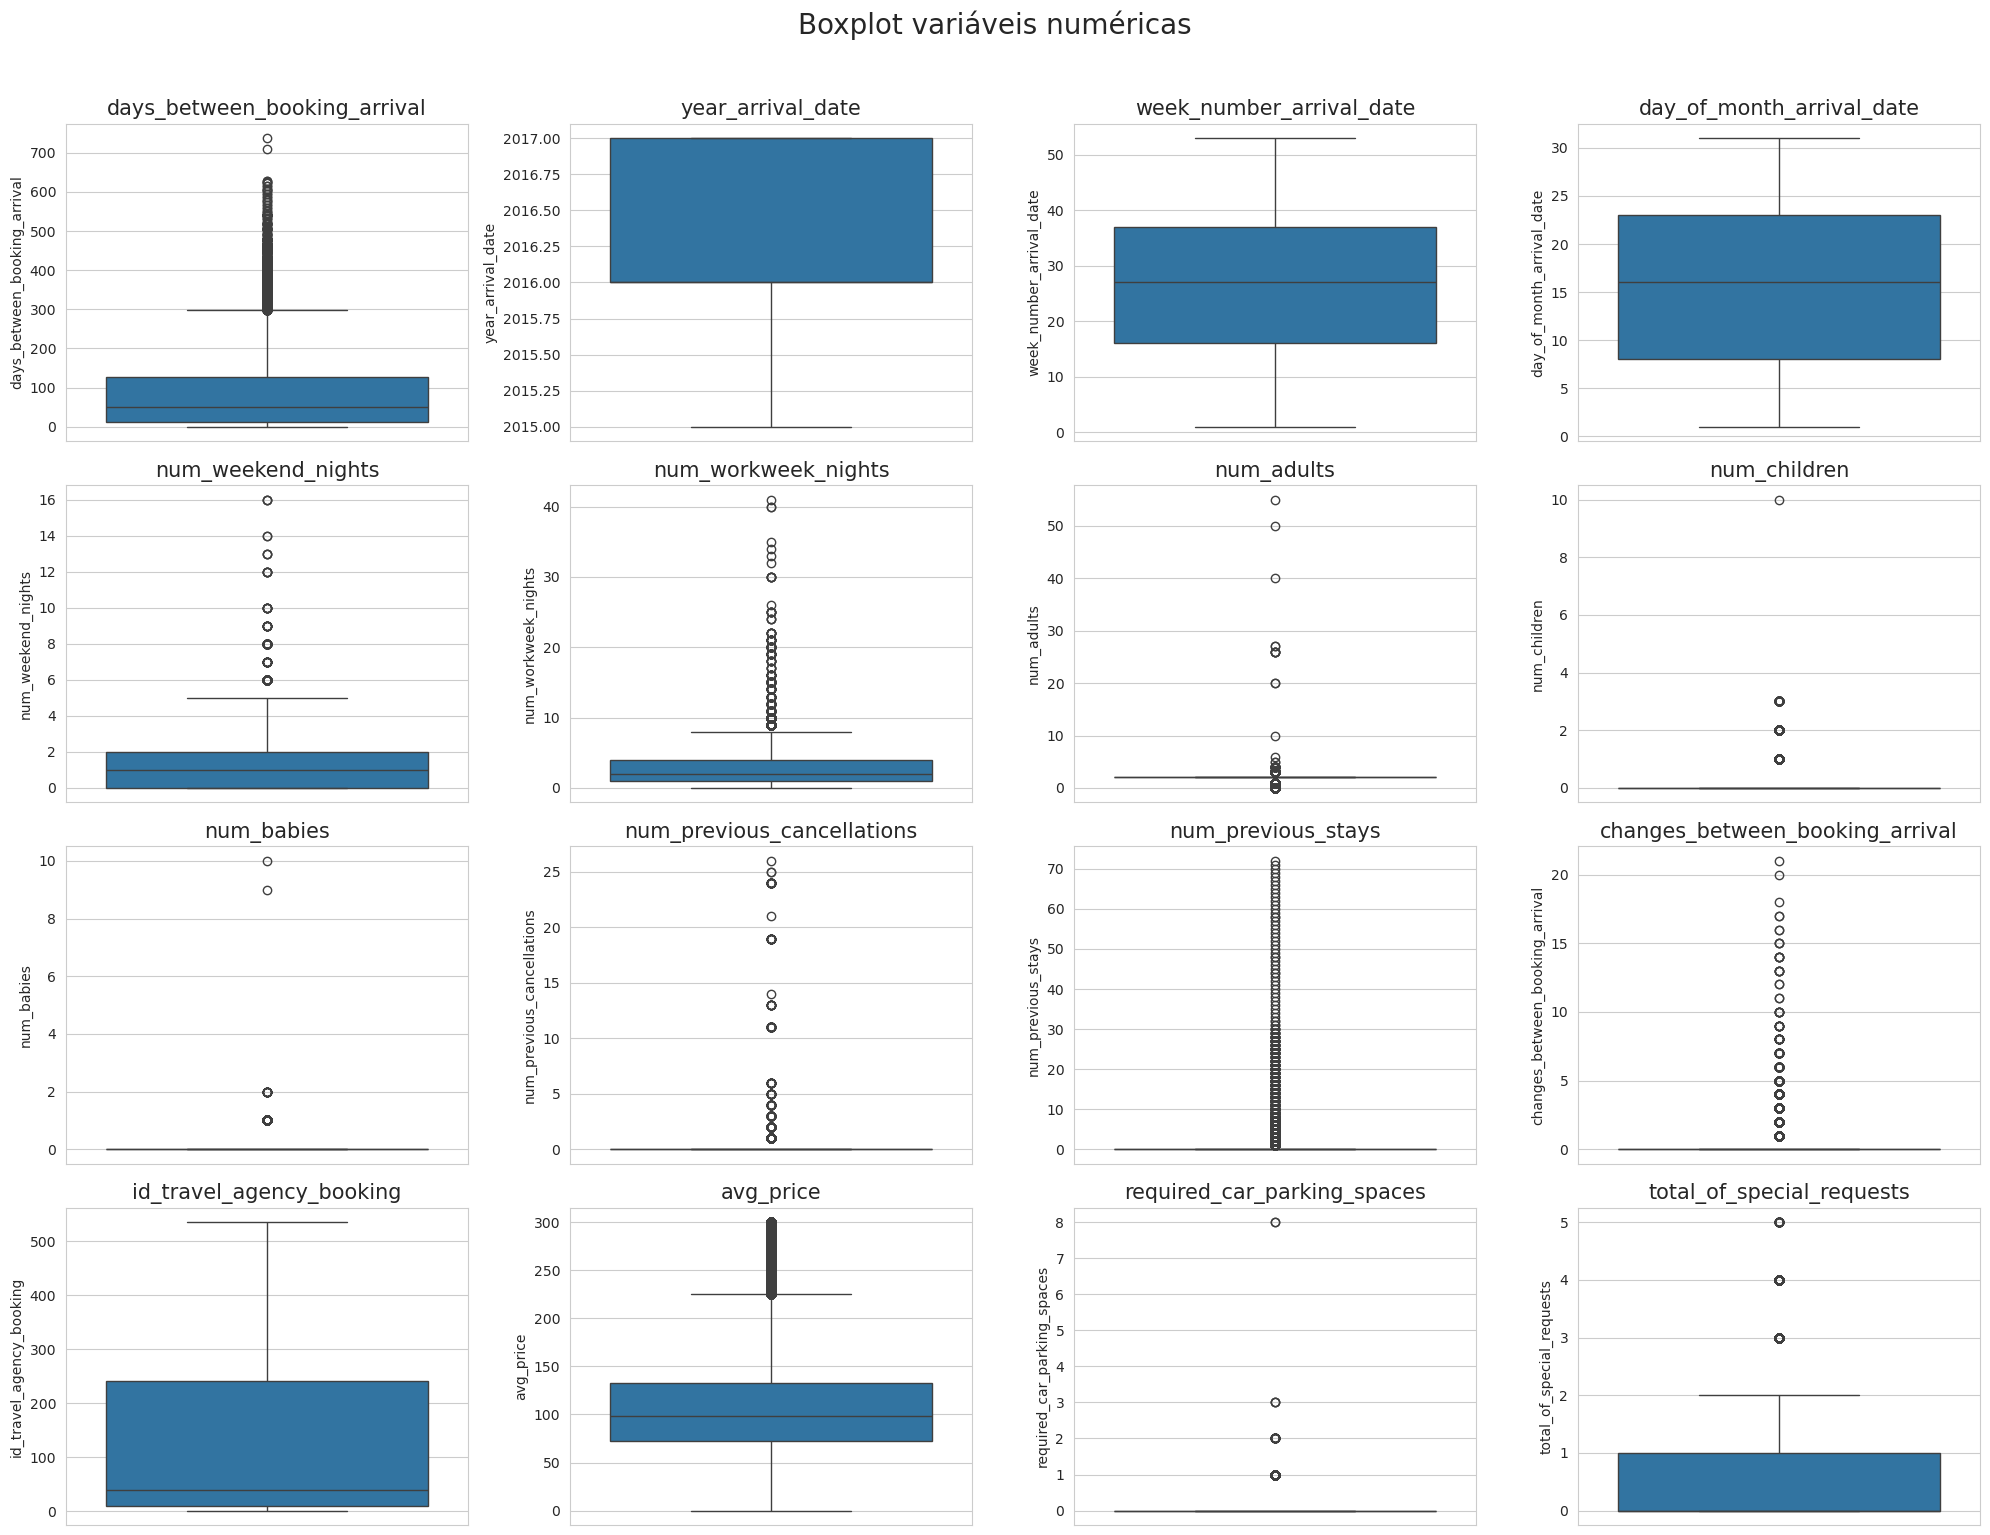

In [ ]:
#Boxplots das variáveis numéricas iniciais.
nrows=4
ncols=4
fig, axes = plt.subplots(nrows, ncols, figsize=(20,15))
for i, col in enumerate(num_cols):
    nrow = i // ncols
    ncol = i % ncols
    g = sns.boxplot(df, y=num_cols[i] , ax=axes[nrow,ncol])
    g.set_title(col, fontdict={'size': 15}, y=1)
    g.set_xlabel('')
    if col in ['year_arrival_date']:
        g.tick_params(axis='x', labelrotation=90)
fig.suptitle('Boxplot variáveis numéricas', y=1.02, size=20)
plt.tight_layout()
plt.show()

##### Dados categóricos

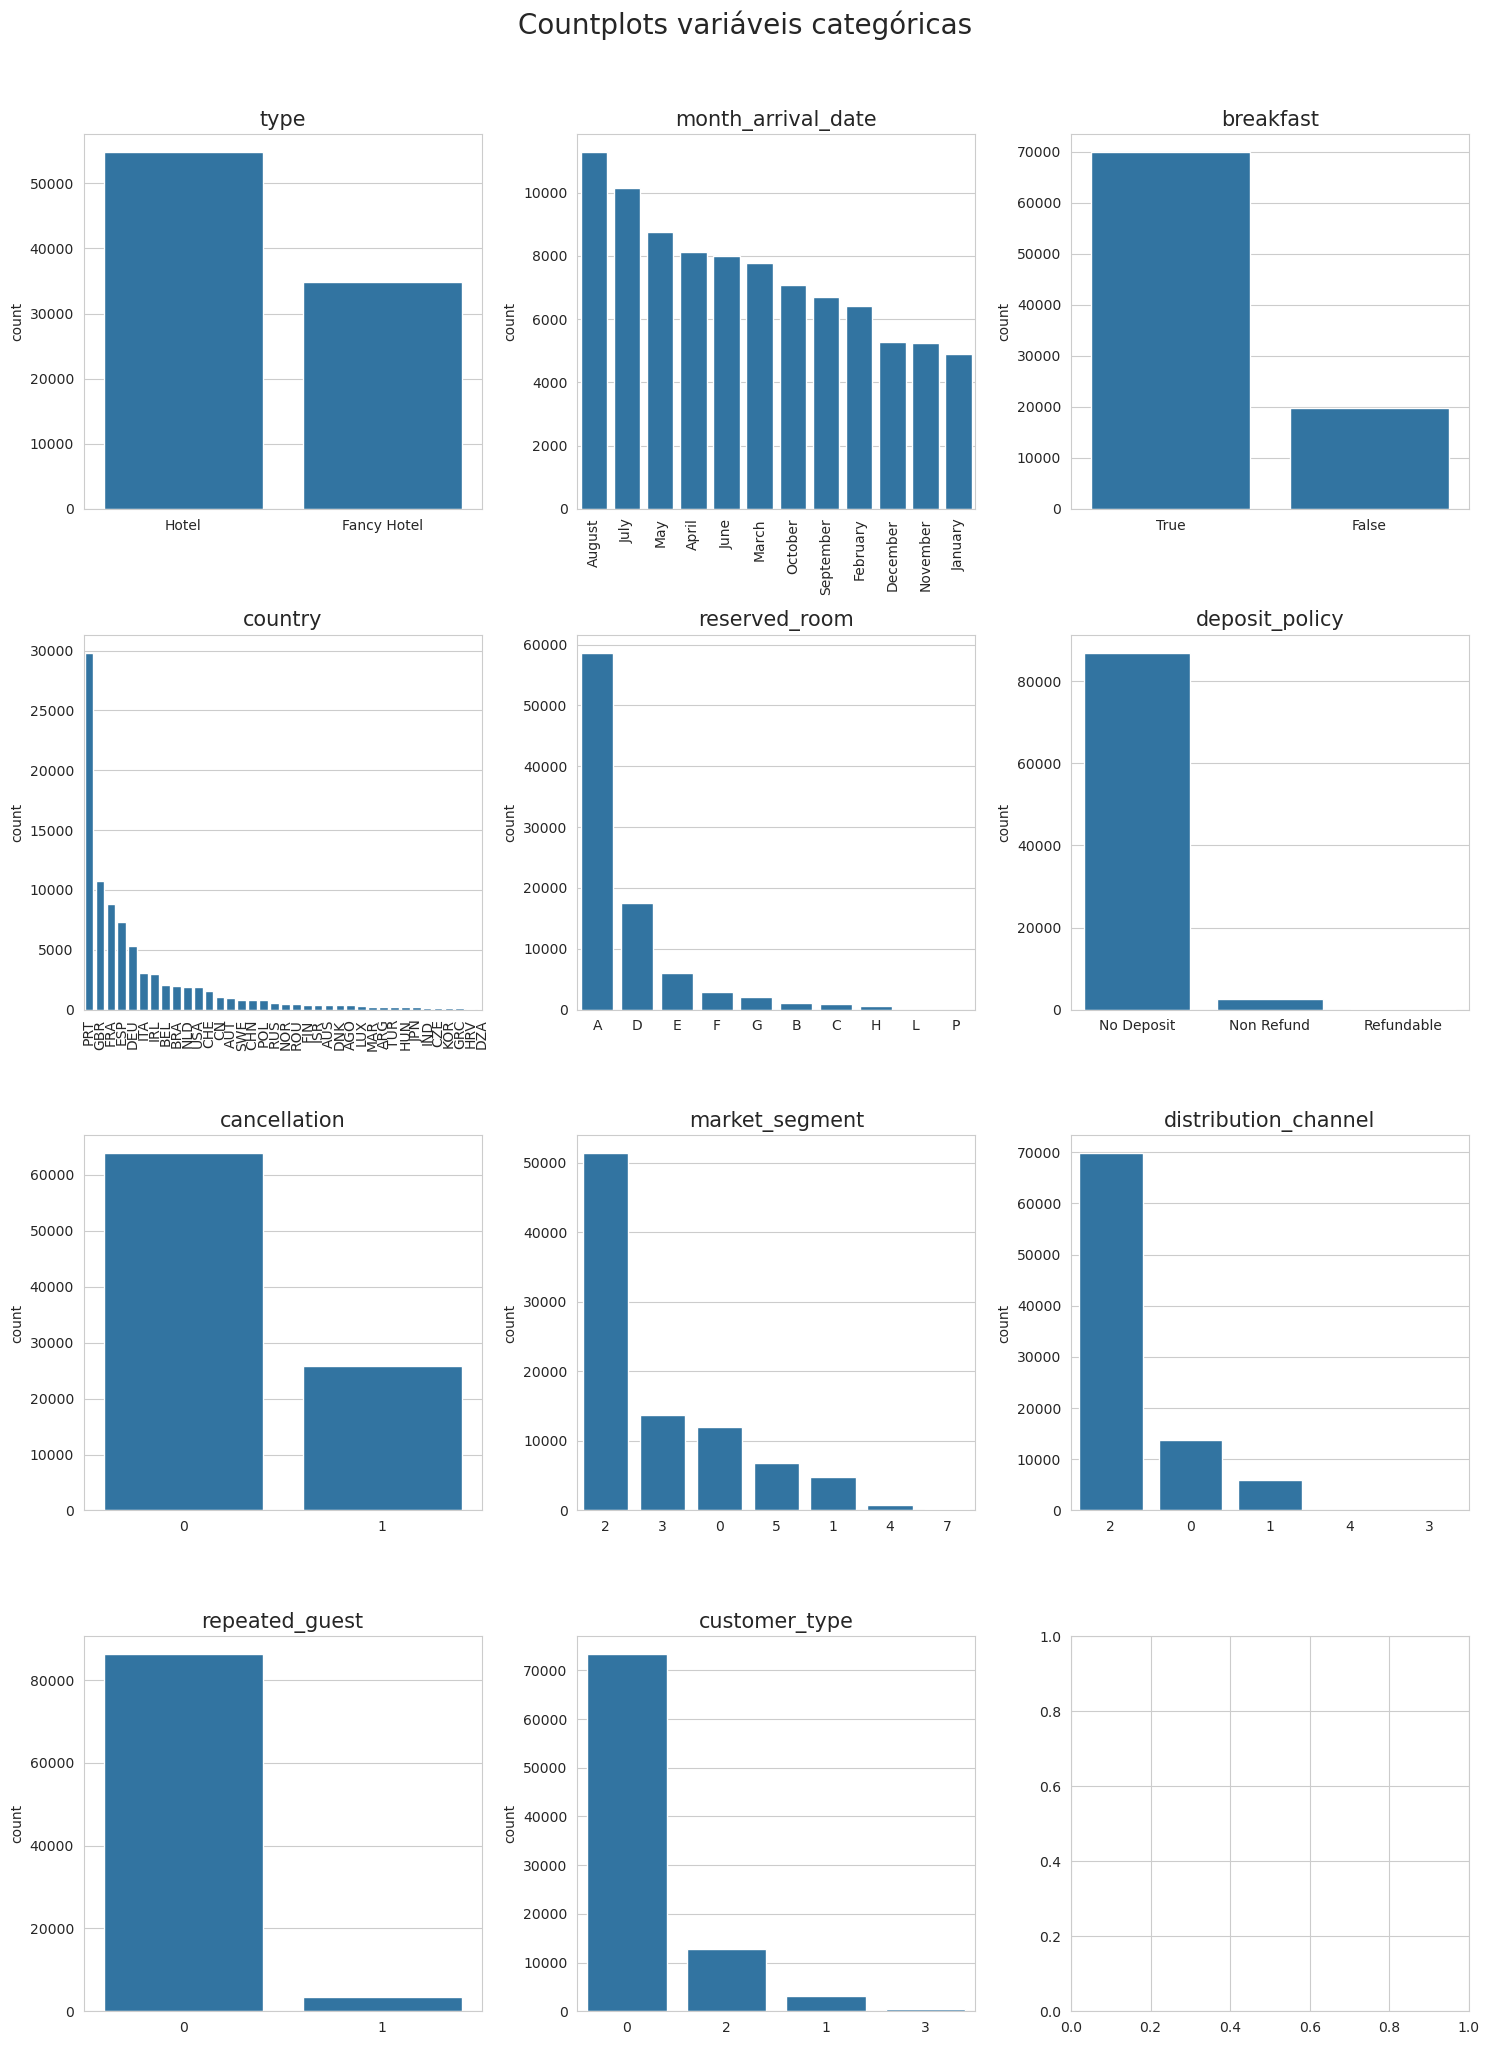

In [ ]:
# Countplots das variáveis categóricas iniciais.
nrows=4
ncols=3
fig, axes = plt.subplots(nrows, ncols, figsize=(15,20))
for i, col in enumerate(cat_cols):
    nrow = i // ncols
    ncol = i % ncols
    g = sns.countplot(df, x=cat_cols[i], ax=axes[nrow,ncol], order=df[col].value_counts().sort_values(ascending=False).index.tolist())
    g.set_title(col, fontdict={'size': 15}, y=1)
    g.set_xlabel('')
    if col=='country':
        g.tick_params(axis='x', labelrotation=90)
        g.set_xlim(xmax='DZA')
    if col =='month_arrival_date':
        g.tick_params(axis='x', labelrotation=90)
fig.suptitle('Countplots variáveis categóricas', y=1.02, size=20)
plt.tight_layout()
plt.show()

##### Dados categóricos criados

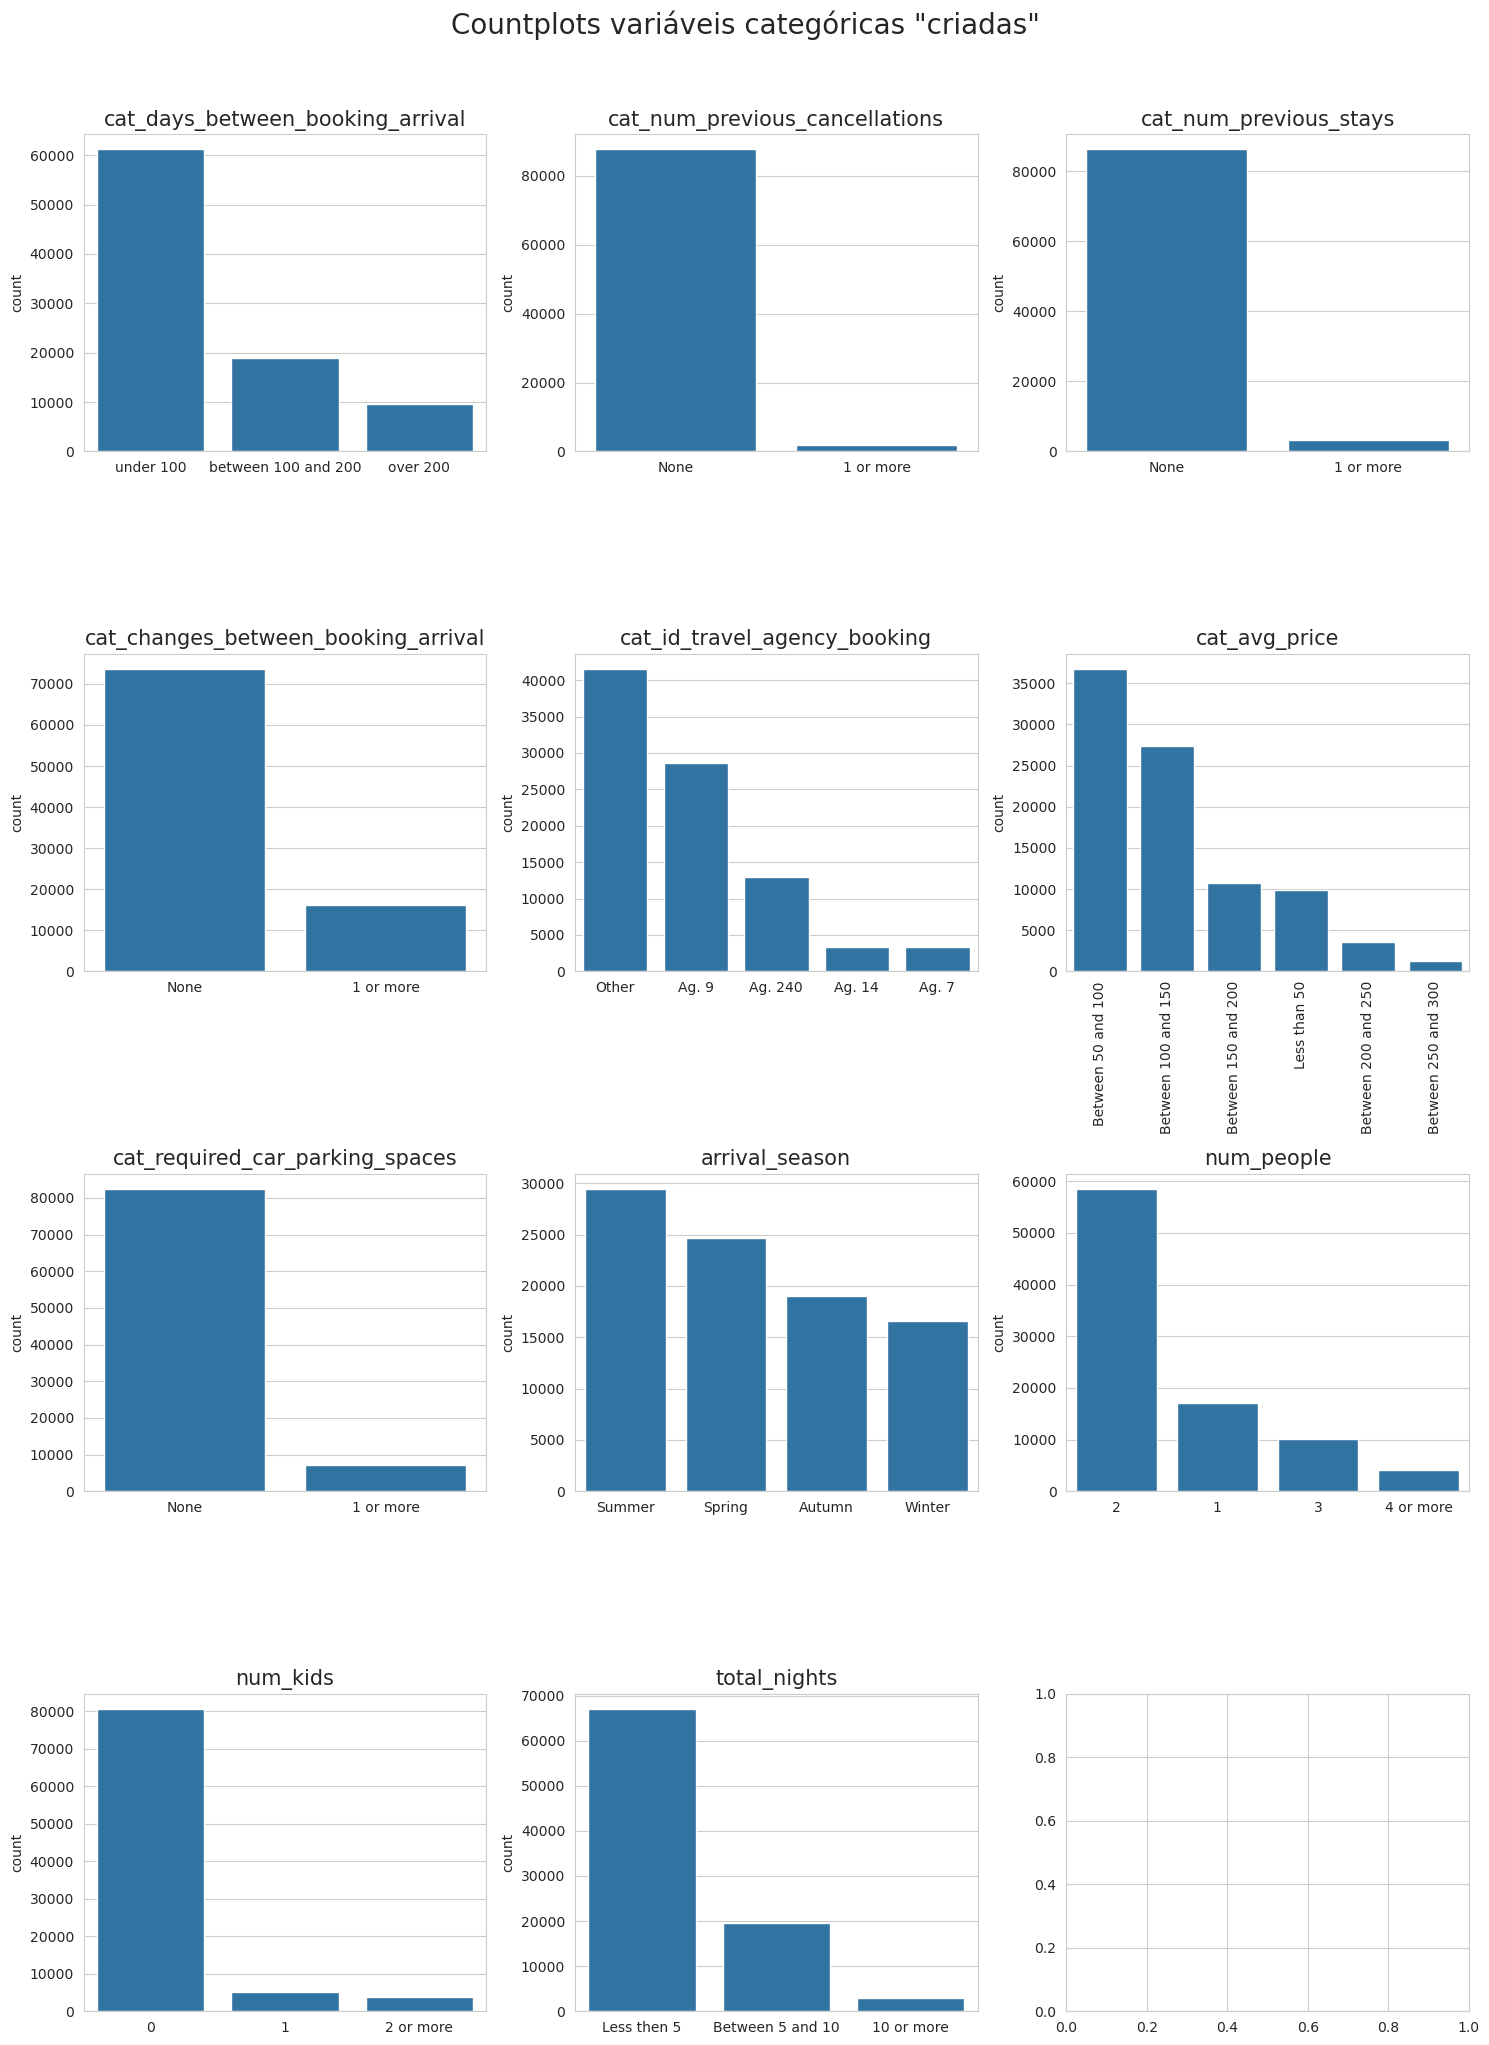

In [ ]:
# Countplots das variáveis categóricas iniciais.
nrows=4
ncols=3
fig, axes = plt.subplots(nrows, ncols, figsize=(15,20))
for i, col in enumerate(df_cat.columns.tolist()):
    nrow = i // ncols
    ncol = i % ncols
    g = sns.countplot(df_cat, x=df_cat.columns.tolist()[i], ax=axes[nrow,ncol], order=df_cat[col].value_counts().sort_values(ascending=False).index.tolist())
    g.set_title(col, fontdict={'size': 15}, y=1)
    g.set_xlabel('')
    if col == 'cat_avg_price':
        g.tick_params(axis='x', labelrotation=90)
fig.suptitle('Countplots variáveis categóricas "criadas"', y=1.02, size=20)
plt.tight_layout()
plt.show()

Insights:
- Variável "cancellation" = desbalanceada

### Análise bivariada (target x features)

#### Numéricas x target

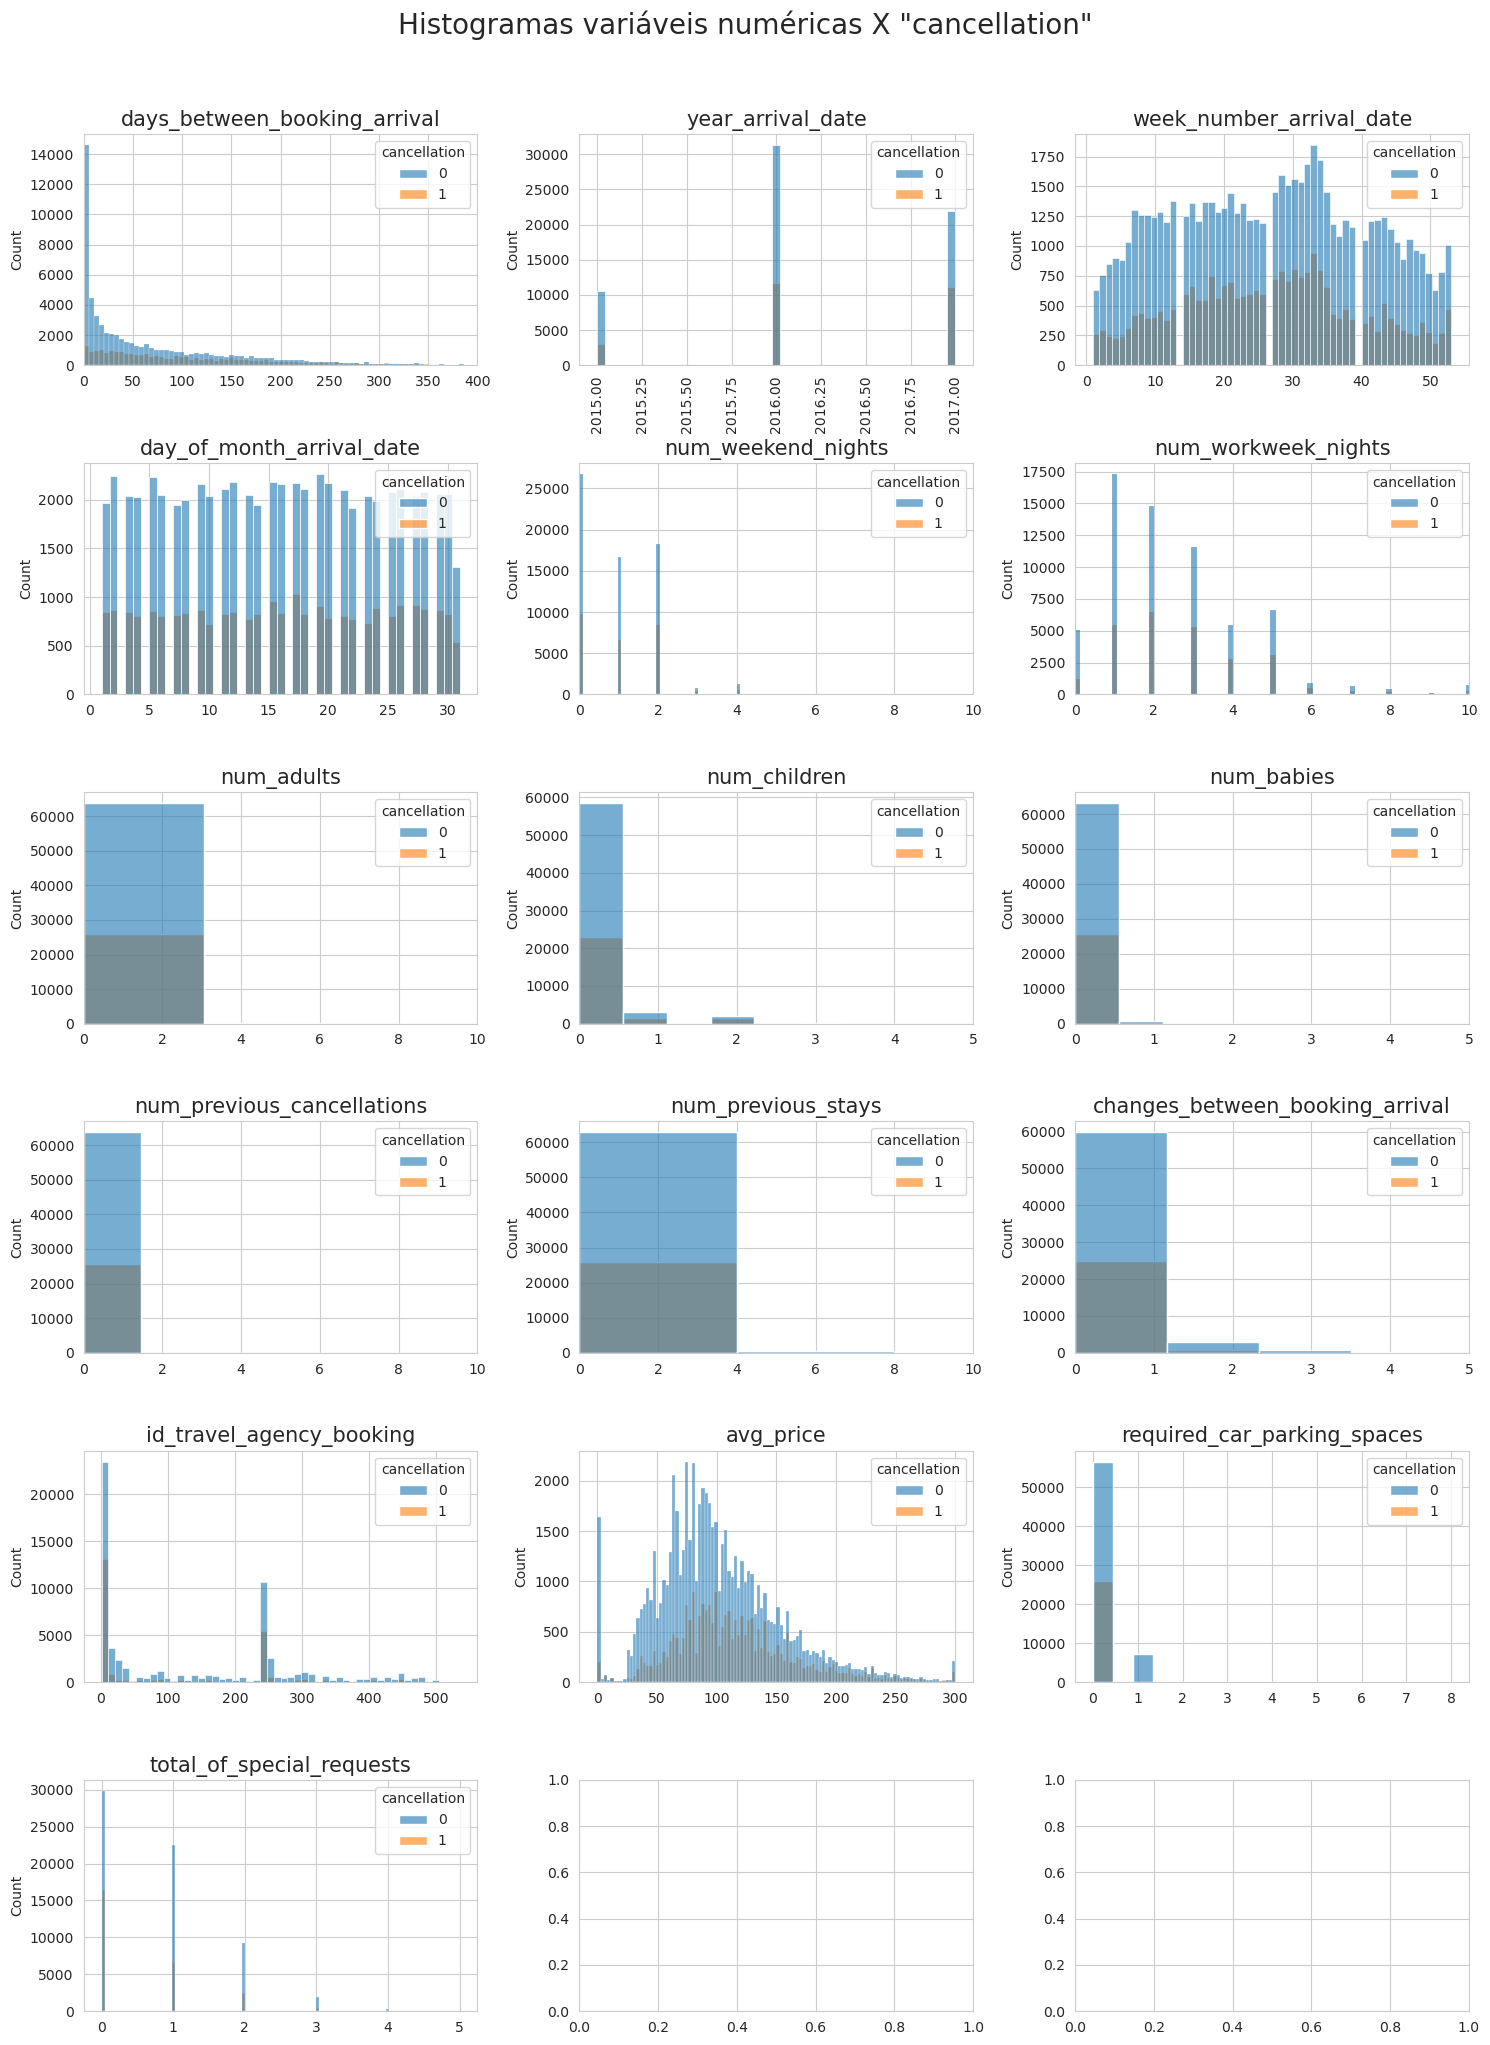

In [ ]:
nrows=6
ncols=3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 20))
for i, col in enumerate(num_cols):
    nrow = i // ncols
    ncol = i % ncols
    g = sns.histplot(df, x=num_cols[i], hue='cancellation' , ax=axes[nrow,ncol], log_scale=False, alpha=.6)
    g.set_title(col, fontdict={'size': 15}, y=1)
    g.set_xlabel('')
    if col in ['year_arrival_date']:
        g.tick_params(axis='x', labelrotation=90)
    if col == 'days_between_booking_arrival':
        g.set_xlim(0, 400)
    if col in ['num_workweek_nights','num_weekend_nights', 'num_people', 'num_adults', 'num_previous_stays', 'num_previous_cancellations']:
        g.set_xlim(0, 10)
    if col in ['total_nights']:
        g.set_xlim(0, 15)
    if col in ['num_children', 'num_kids', 'num_babies', 'changes_between_booking_arrival']:
        g.set_xlim(0, 5)
fig.suptitle('Histogramas variáveis numéricas X "cancellation"', y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

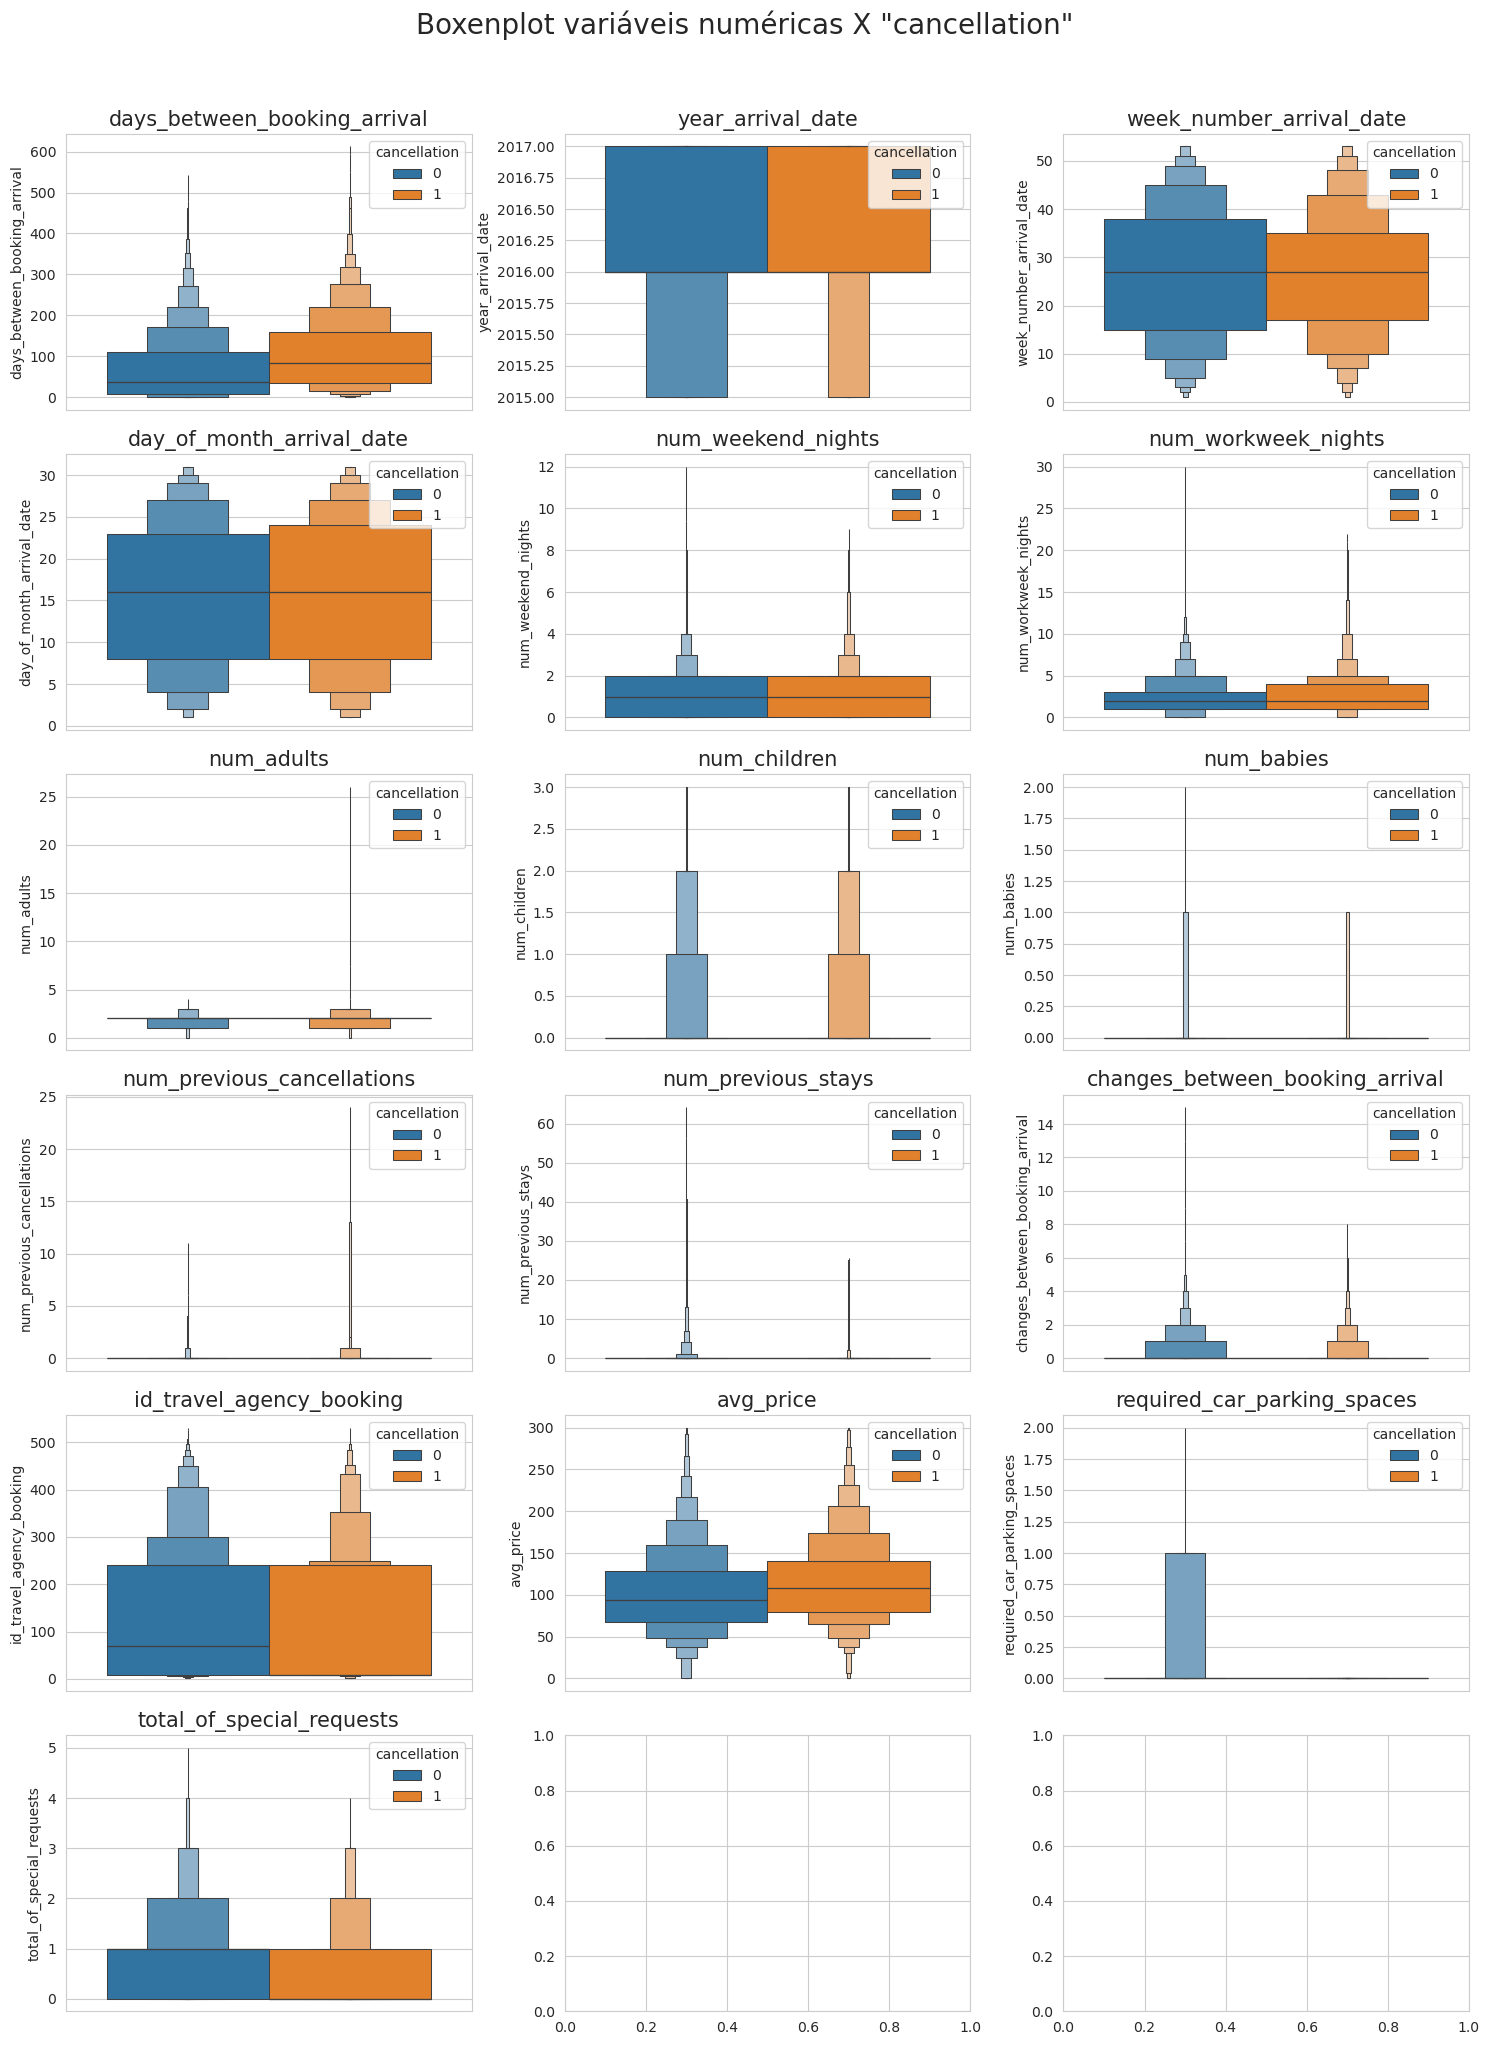

In [ ]:
# Outliers removidos para melhor visualização
nrows=6
ncols=3
fig, axes = plt.subplots(nrows, ncols, figsize=(15,20))
for i, col in enumerate(num_cols):
    nrow = i // ncols
    ncol = i % ncols
    g = sns.boxenplot(df, y=num_cols[i], hue='cancellation' , ax=axes[nrow,ncol], showfliers=False)
    g.set_title(col, fontdict={'size': 15}, y=1)
    g.set_xlabel('')
    if col in ['year_arrival_date']:
        g.tick_params(axis='x', labelrotation=90)
fig.suptitle('Boxenplot variáveis numéricas X "cancellation"', y=1.02, size=20)
plt.tight_layout()
plt.show()

#### Categóricas x target

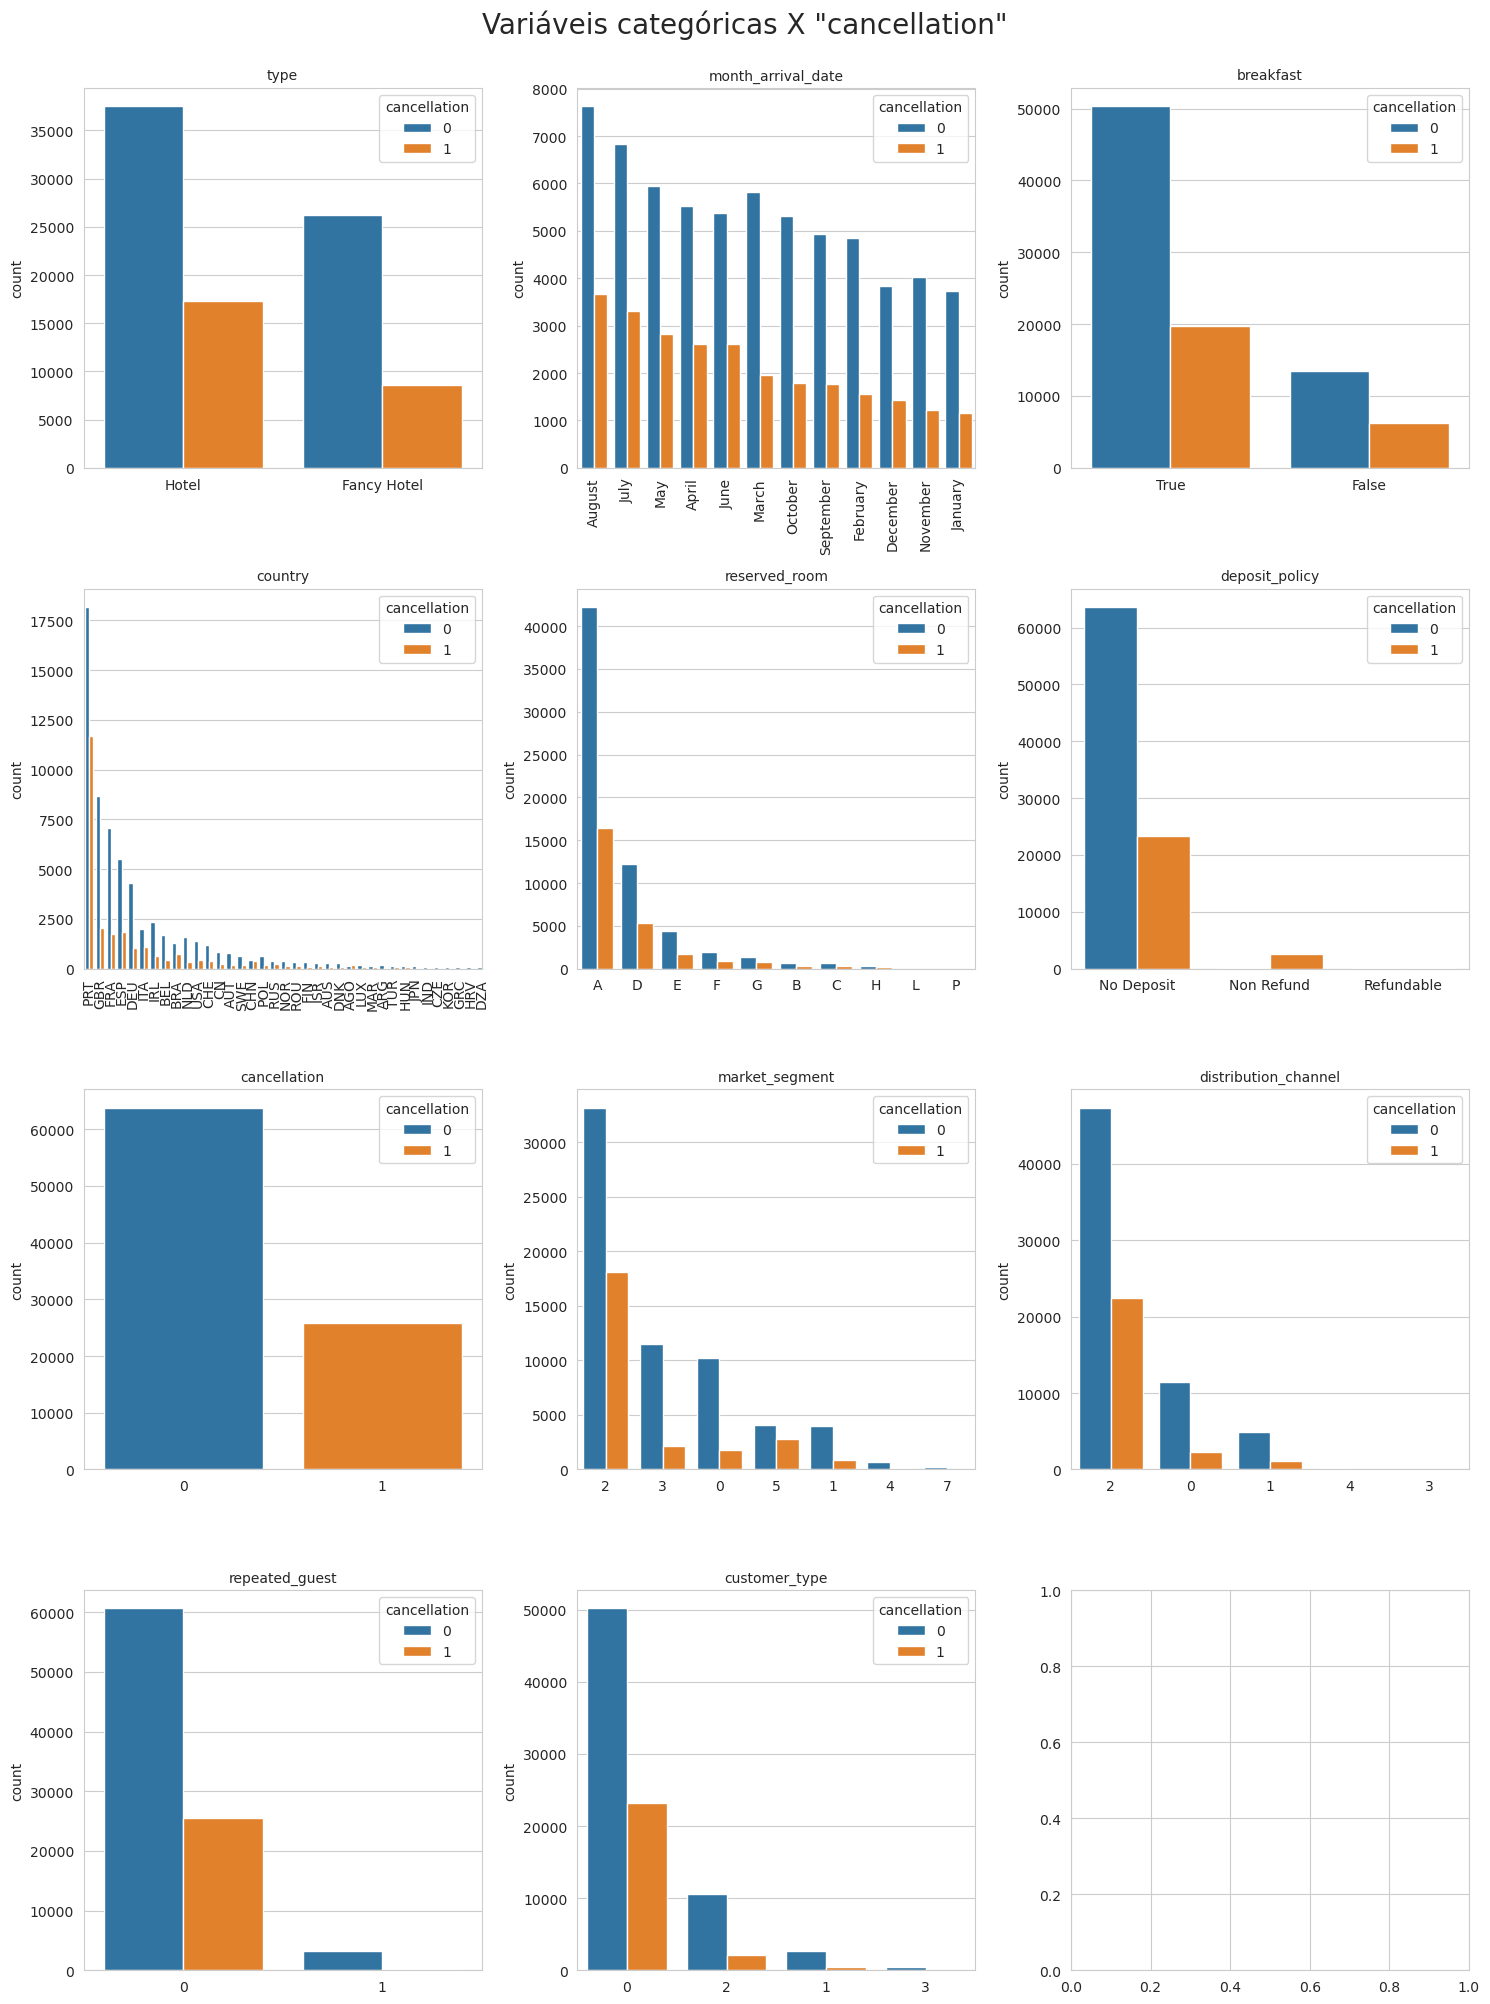

In [ ]:
nrows=4
ncols=3
fig, axes = plt.subplots(nrows, ncols, figsize=(15,20))
for i, col in enumerate(cat_cols):
    nrow = i // ncols
    ncol = i % ncols
    g = sns.countplot(df, x=cat_cols[i], ax=axes[nrow,ncol], hue='cancellation', order=df[col].value_counts().sort_values(ascending=False).index.tolist())
    g.set_title(col, fontdict={'size': 10}, y=1)
    g.set_xlabel('')
    if col=='country':
        g.tick_params(axis='x', labelrotation=90)
        g.set_xlim(xmax='DZA')
    if col =='month_arrival_date':
        g.tick_params(axis='x', labelrotation=90)
fig.suptitle('Variáveis categóricas X "cancellation"', y=1, size=20)
plt.tight_layout()
plt.show()

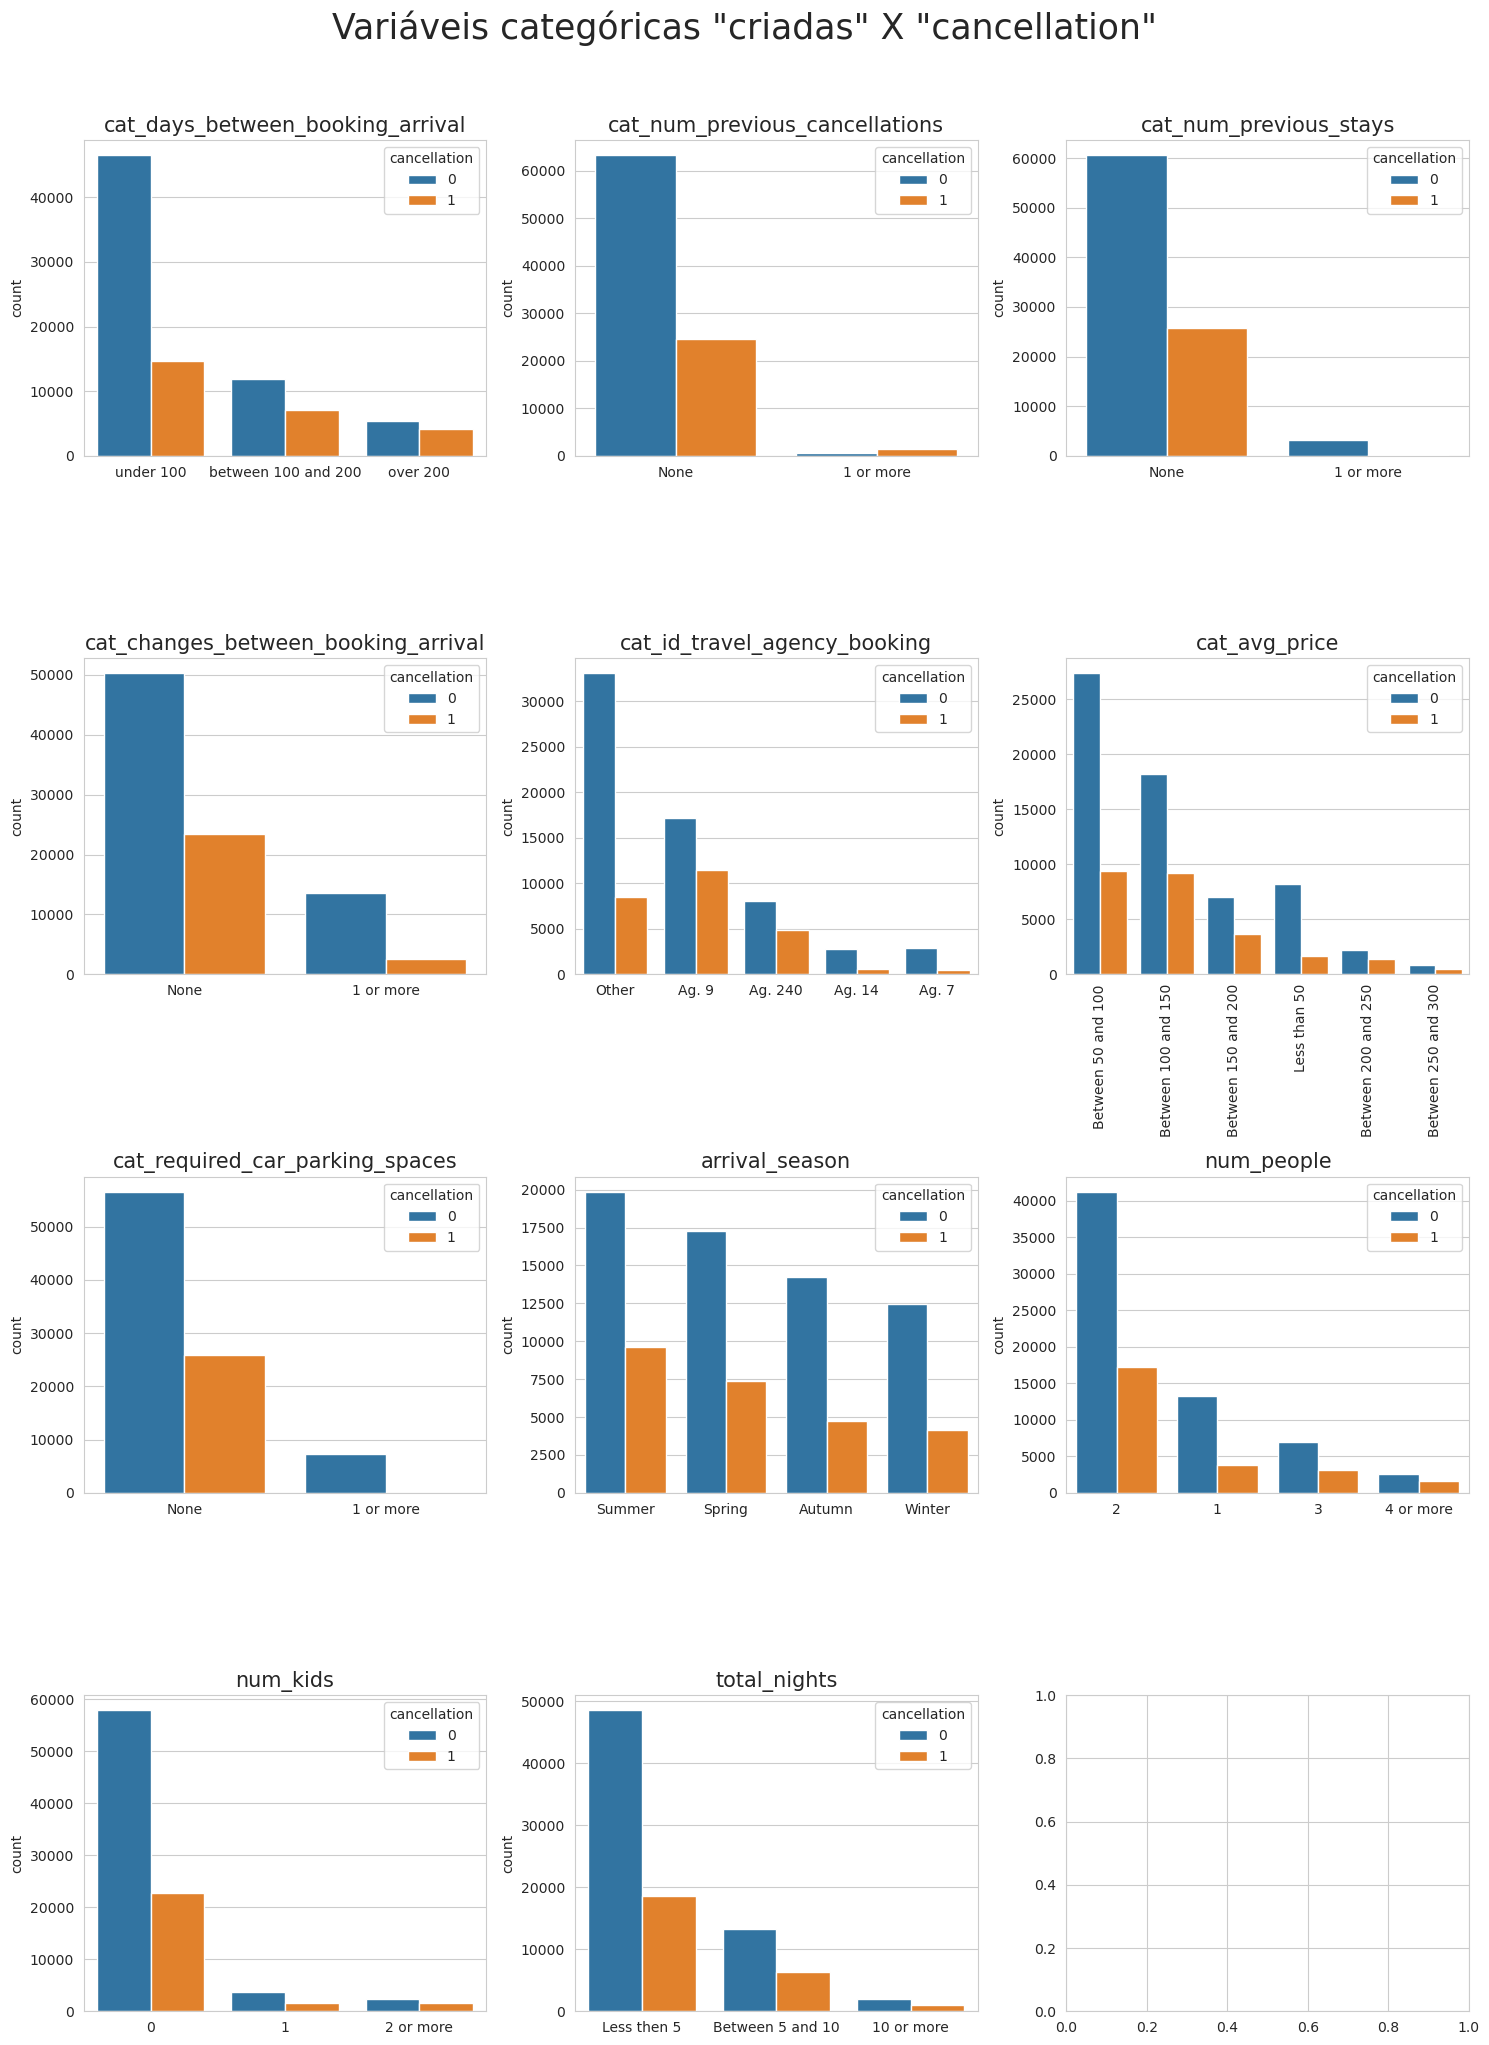

In [ ]:
nrows=4
ncols=3
fig, axes = plt.subplots(nrows, ncols, figsize=(15,20))
for i, col in enumerate(df_cat.columns.tolist()):
    nrow = i // ncols
    ncol = i % ncols
    g = sns.countplot(pd.concat([df_cat, df['cancellation']], axis=1), x=df_cat.columns.tolist()[i], hue='cancellation', ax=axes[nrow,ncol], order=df_cat[col].value_counts().sort_values(ascending=False).index.tolist())
    g.set_title(col, fontdict={'size': 15}, y=1)
    g.set_xlabel('')
    if col == 'cat_avg_price':
        g.tick_params(axis='x', labelrotation=90)
fig.suptitle('Variáveis categóricas "criadas" X "cancellation"', y=1.02, size=25)
plt.tight_layout()
plt.show()

Hipóteses:
- Aparentemente, quanto maior o 'avg_price', maiores as taxas de cancelamento.
- As duas 'id_travel_agency_booking' que possuem maior contagem, também possuem as maiores taxas de cancelamento.
- Aparentemente, quanto maior a antecedencia com que foi reservado o hotel, maior a chance de cancelamento.
- Aparentemente, se a reserva foi feita em 2017, houve maior taxa de cancelamento.
- Não parece haver relação entre mudanças na taxa de cancelamento e 'week_number_arrival_date' e 'day_of_month_arrival_date'.
- Quanto maior 'total_special_requests', menor a taxa de cancelamento.
- Se 'deposit_policy' for 'Non Refund', há menor chance de cancelamento.
- Se 'repeated_guest' for '1', há menor chance de cancelamento
- Aparentemente, 'distribuition_channel' 2, 'customer_type' 0 e 'market_segment' 5 possuem maiores taxas de cancelamento.
- Aparentemente, em 'arrival_season', as taxas de cancelamento são maiores em 'Summer' e 'Spring'.
- 'num_people' e 'num_kids' aparentam ser melhores preditores das taxas de cancelamento do que 'num_adults', 'num_babies' e 'num_children'.
- 'num_people' maior que 3 apresenta maior proporção de cancelamentos. 'num_kids' maior que 1 também.
- Aparentemente, reservas feitas pelas 'Ag. 9' e 'Ag. 240', tiveram maiores taxas de 'cancellation'.
- Aparentemente, quanto maior 'total_nights', maior a taxa de 'cancellation'.
- Se 'required_car_parking_spaces' for 1 ou mais, há redução na taxa de 'cancellation'.
- Ter cancelado 1 ou mais vezes aumenta as taxas de 'cancellation'.

### Encoding

In [ ]:
# Separando 'features' e 'target'.
remove = ['cancellation','num_weekend_nights','num_workweek_nights','num_adults','num_children','num_babies',
          'avg_price','required_car_parking_spaces', 'id_travel_agency_booking','days_between_booking_arrival',
          'changes_between_booking_arrival', 'num_previous_cancellations','num_previous_stays']
X= df.drop(remove, axis=1)
X= pd.concat([X, df_cat], axis=1)
y= df['cancellation']
X.shape, y.shape

((89707, 25), (89707,))

In [ ]:
# Criando lista de colunas que passarão pelo 'encoder'.
enc_cat_cols = [*cat_cols]
enc_cat_cols.remove('cancellation')
[enc_cat_cols.append(col) for col in df_cat.columns.tolist()]


[None, None, None, None, None, None, None, None, None, None, None]

In [ ]:
# encoding
oe = OrdinalEncoder()
X[enc_cat_cols] = oe.fit_transform(X[enc_cat_cols])

### Matrix de correlação

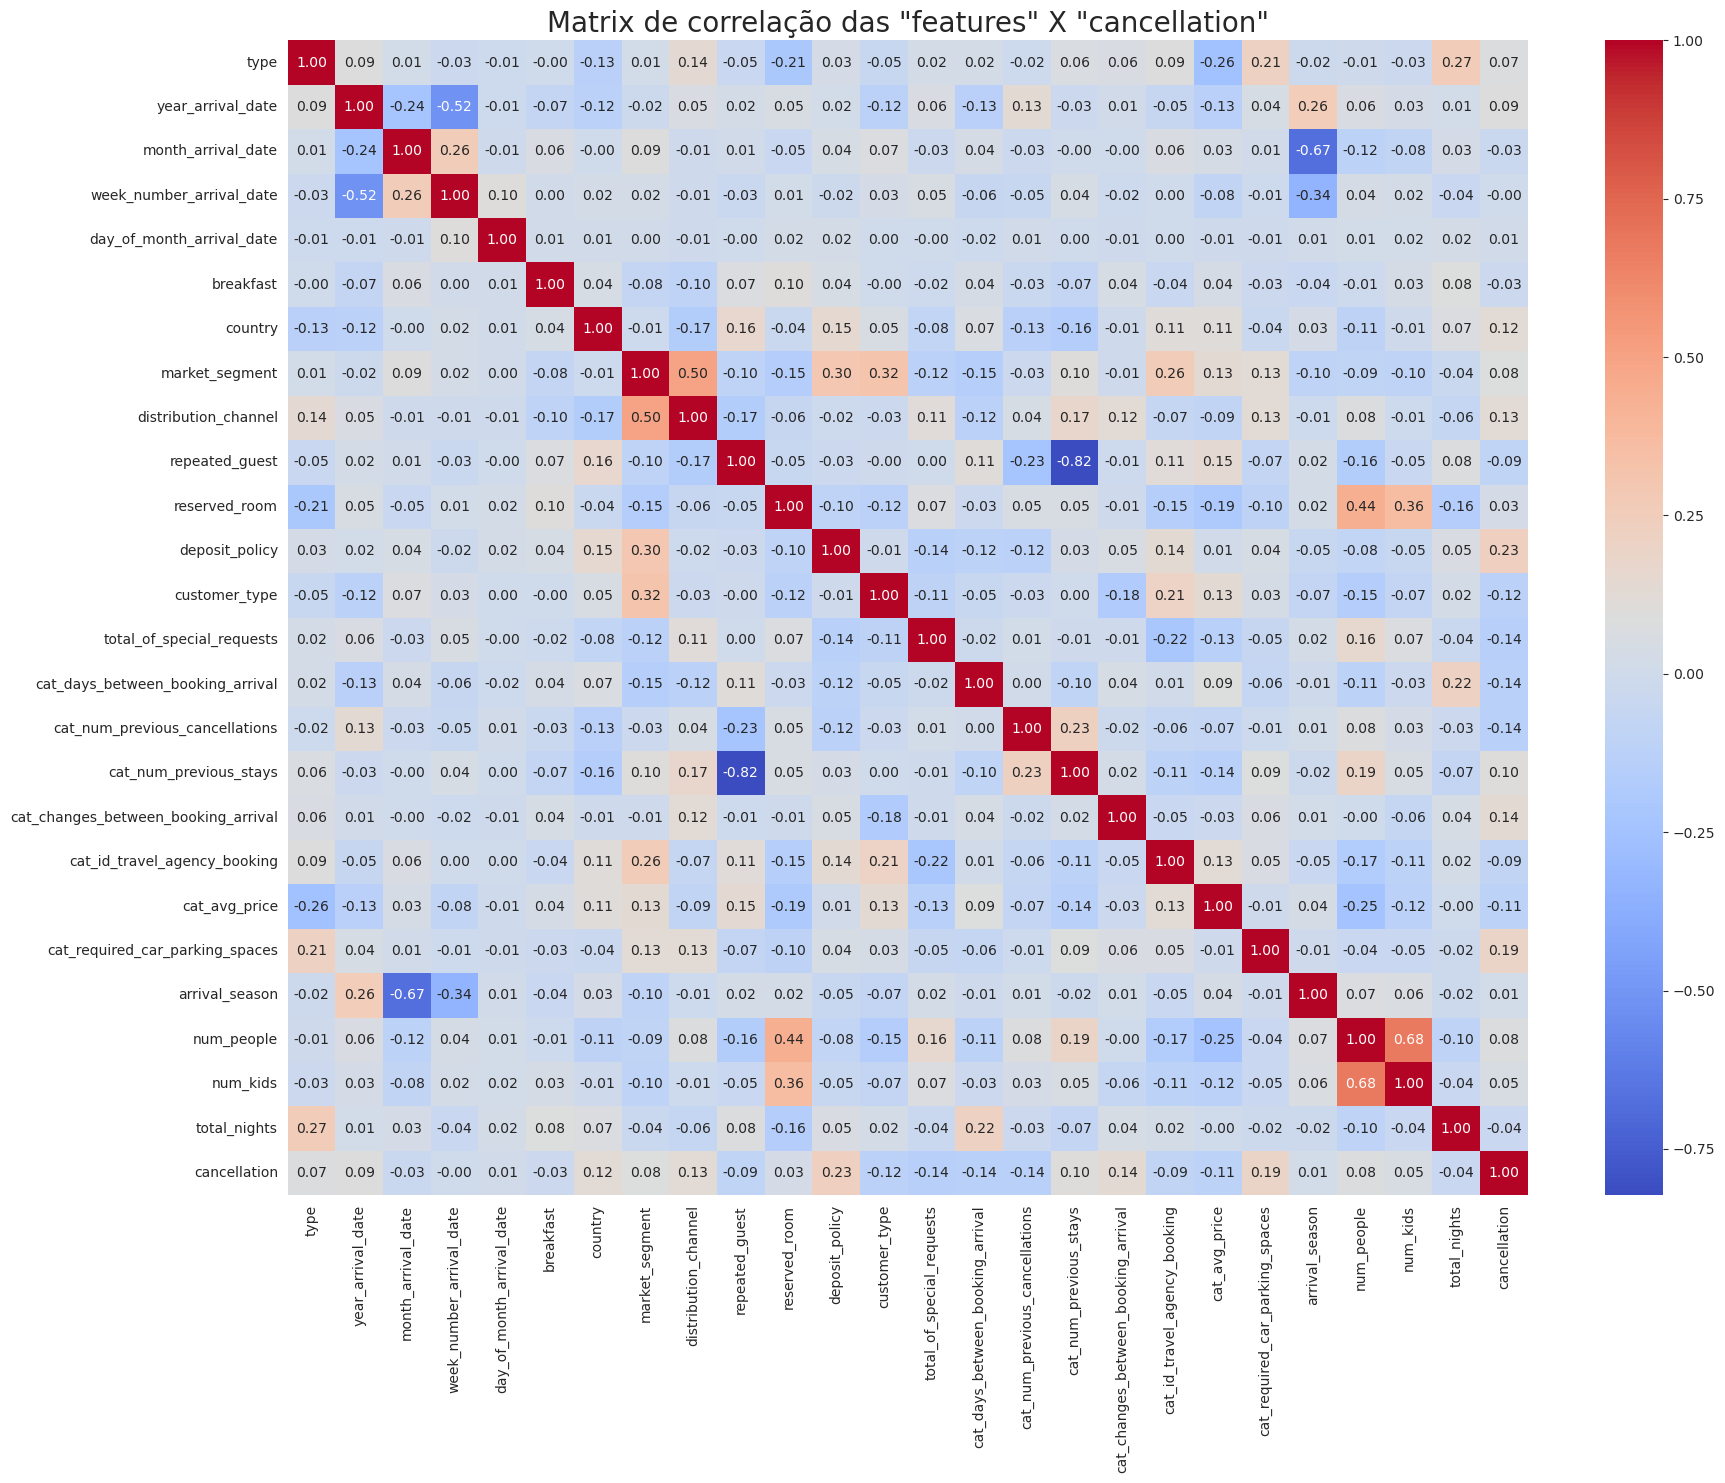

In [ ]:
# Gráfico da matrix de correlação para investigar
# possíveis relações lineares entre as variáveis/target.
plt.figure(figsize=(20,15))
sns.heatmap(pd.concat([X, y], axis=1).corr(method='pearson'), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrix de correlação das "features" X "cancellation"', fontdict={'size':20})
plt.show()

Insight:
- Nenhuma variável possui correlação forte com 'cancellation'


## Modelagem

#### Criando sets de treino, validação e teste

b) Desenvolva um modelo preditivo de classificação para identificar cancelamentos e utilize
métricas adequadas para argumentar a efetividade do modelo;

In [ ]:
# Criando sets de treino, validação e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, shuffle=True, stratify=y_train, random_state=42)


#### Modelos iniciais

In [ ]:
# Normalização: desvio padrão=1 / média = 0
sca = StandardScaler()
sca_X_train = sca.fit_transform(X_train)
sca_X_val = sca.transform(X_val)
sca_X_test = sca.transform(X_test)

Utilizarei as bibliotecas 'lazypredict' e 'optuna' para auxiliar na modelagem. A primeira traz agilidade para uma avaliação inicial de todos os modelos de classificação presentes na biblioteca 'scikit-learn'. O segundo possibilita o 'hiperparameter tunning' com mais eficiência do que ferramentas como o 'GridSearchCV' ou 'RandomSearchCV'.

In [ ]:
lc = LazyClassifier()
models, predictions = lc.fit(X_train, X_val, y_train, y_val)

100%|███████████████████████████████████████████████████████████████████████████████████| 29/29 [02:54<00:00,  6.00s/it]

[LightGBM] [Info] Number of positive: 16561, number of negative: 40851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 57412, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288459 -> initscore=-0.902881
[LightGBM] [Info] Start training from score -0.902881


In [ ]:
models.sort_values(by='F1 Score', ascending=False)

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.84               0.78     0.78      0.83   
LGBMClassifier                     0.84               0.78     0.78      0.83   
RandomForestClassifier             0.83               0.77     0.77      0.83   
BaggingClassifier                  0.82               0.76     0.76      0.81   
ExtraTreesClassifier               0.82               0.76     0.76      0.81   
SVC                                0.82               0.74     0.74      0.81   
DecisionTreeClassifier             0.79               0.75     0.75      0.79   
KNeighborsClassifier               0.79               0.73     0.73      0.79   
ExtraTreeClassifier                0.78               0.73     0.73      0.78   
AdaBoostClassifier                 0.79               0.70     0.70      0.78   
BernoulliNB                        0.77               0.68     0.68      0.76   
NuSVC                              0.79               0.65     0.65      0.75   
LogisticRegression                 0.77               0.66     0.66      0.75   
CalibratedClassifierCV             0.77               0.66     0.66      0.75   
LinearSVC                          0.77               0.65     0.65      0.74   
LinearDiscriminantAnalysis         0.77               0.64     0.64      0.74   
RidgeClassifier                    0.77               0.63     0.63      0.73   
RidgeClassifierCV                  0.77               0.63     0.63      0.73   
PassiveAggressiveClassifier        0.74               0.63     0.63      0.72   
NearestCentroid                    0.70               0.71     0.71      0.72   
SGDClassifier                      0.76               0.60     0.60      0.71   
Perceptron                         0.70               0.63     0.63      0.70   
DummyClassifier                    0.71               0.50     0.50      0.59   
GaussianNB                         0.40               0.57     0.57      0.33   
QuadraticDiscriminantAnalysis      0.39               0.57     0.57      0.33   

                               Time Taken  
Model                                      
XGBClassifier                        0.50  
LGBMClassifier                       0.18  
RandomForestClassifier               4.01  
BaggingClassifier                    1.41  
ExtraTreesClassifier                 3.64  
SVC                                 68.99  
DecisionTreeClassifier               0.22  
KNeighborsClassifier                 0.90  
ExtraTreeClassifier                  0.06  
AdaBoostClassifier                   1.05  
BernoulliNB                          0.05  
NuSVC                               87.60  
LogisticRegression                   0.09  
CalibratedClassifierCV               0.94  
LinearSVC                            3.69  
LinearDiscriminantAnalysis           0.07  
RidgeClassifier                      0.04  
RidgeClassifierCV                    0.07  
PassiveAggressiveClassifier          0.08  
NearestCentroid                      0.04  
SGDClassifier                        0.19  
Perceptron                           0.07  
DummyClassifier                      0.03  
GaussianNB                           0.04  
QuadraticDiscriminantAnalysis        0.05

In [ ]:
best_models = ['RandomForestClassifier', 'LGBMClassifier', 'XGBClassifier']

### XGBOOST

In [ ]:
def objective(trial):
    params = {
    'device':'cpu',
    # 'n_jobs':-1,
    # 'num_class' : 2,
    'objective':'binary:logistic',
    # "eval_metric":"auc",
    "num_boost_round": trial.suggest_int('num_boost_round', 10, 500),
    "max_depth" : trial.suggest_int("max_depth", 1, 10),
    "grow_policy": trial.suggest_categorical("grow_policy",["depthwise", "lossguide"]),
    "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1),
    "booster": trial.suggest_categorical("booster", ['gbtree', 'dart']),
    "subsample": trial.suggest_float('subsample',0., 1.),
    "num_paralel_tree": 128,
    "tree_method": 'hist',
    "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
    "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 100, log=True),
    "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
    "verbose":0
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, evals=[(dval,'logloss')], early_stopping_rounds=5, num_boost_round = params['num_boost_round'], verbose_eval=0)
    y_pred = model.predict(dval).round()
    score = f1_score(y_val, y_pred)
    return score

In [ ]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=150)

[I 2024-05-20 20:48:08,092] A new study created in memory with name: no-name-f9b57465-7d29-4e9c-93a8-f65e89f66e54
[I 2024-05-20 20:48:08,206] Trial 0 finished with value: 0.5973657024793388 and parameters: {'num_boost_round': 219, 'max_depth': 8, 'grow_policy': 'depthwise', 'learning_rate': 0.9762844236429371, 'booster': 'dart', 'subsample': 0.20166675944297363, 'lambda': 1.1443203876370993e-08, 'alpha': 0.1759192496096892, 'colsample_bytree': 0.260544261327179, 'min_child_weight': 5.93118074847707e-05, 'gamma': 4.285884944909191e-08}. Best is trial 0 with value: 0.5973657024793388.
[I 2024-05-20 20:48:08,322] Trial 1 finished with value: 0.6679497049012061 and parameters: {'num_boost_round': 16, 'max_depth': 8, 'grow_policy': 'depthwise', 'learning_rate': 0.8808316846894433, 'booster': 'dart', 'subsample': 0.41175301136281595, 'lambda': 0.045706995296815524, 'alpha': 0.9118276676958506, 'colsample_bytree': 0.37693640651424903, 'min_child_weight': 2.3069769139830657e-06, 'gamma': 0.198

In [ ]:
study.best_value

0.7021413001666881

In [ ]:
study.best_params

{'num_boost_round': 77,
 'max_depth': 8,
 'grow_policy': 'depthwise',
 'learning_rate': 0.39502849378967236,
 'booster': 'dart',
 'subsample': 0.975316755703365,
 'lambda': 4.075668711284002e-06,
 'alpha': 3.5955899799065976,
 'colsample_bytree': 0.5714314827569386,
 'min_child_weight': 5.002485339374416e-06,
 'gamma': 2.473557597211264e-06}

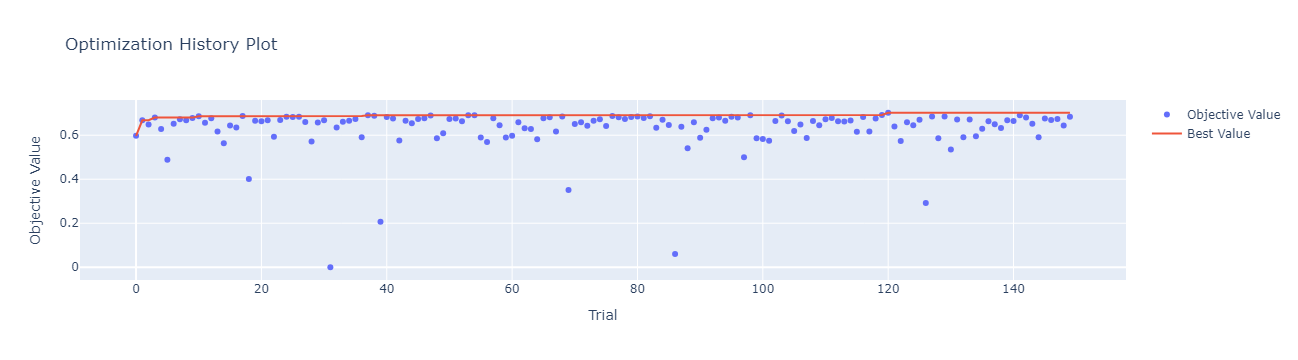

In [ ]:
optuna.visualization.plot_optimization_history(study)

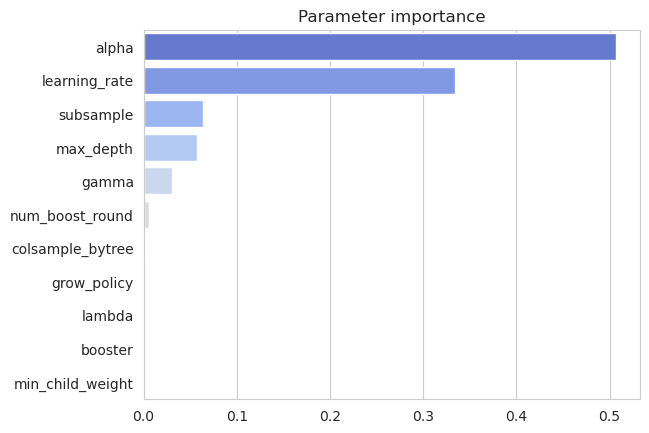

In [ ]:
sns.barplot(optuna.importance.get_param_importances(study), orient='h',palette='coolwarm')
plt.title('Parameter importance')
plt.show()

In [ ]:
clf = xgb.XGBClassifier(**study.best_params, objective='binary:logistic', n_estimators=study.best_params['num_boost_round'], device='cpu', verbose=0)

In [ ]:
clf.fit(X_train, y_train)

XGBClassifier(alpha=3.5955899799065976, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5714314827569386, device='cpu',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.473557597211264e-06,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=4.075668711284002e-06,
              learning_rate=0.39502849378967236, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=5.002485339374416e-06, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=77,
              n_jobs=None, ...)

In [ ]:
clf.score(X_val, y_val)

0.8381523026544974

In [ ]:
precision_score(y_val, clf.predict(X_val))

0.7482918830281498

In [ ]:
recall_score(y_val, clf.predict(X_val))

0.6613526570048309

In [ ]:
f1_score(y_val, clf.predict(X_val))

0.7021413001666881

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_val, clf.predict_proba(X_val)[:, 1])

In [ ]:
def plot_prec_rec_curve(recall, precision):
    plt.figure(figsize=(6, 6))  # Set figure size
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

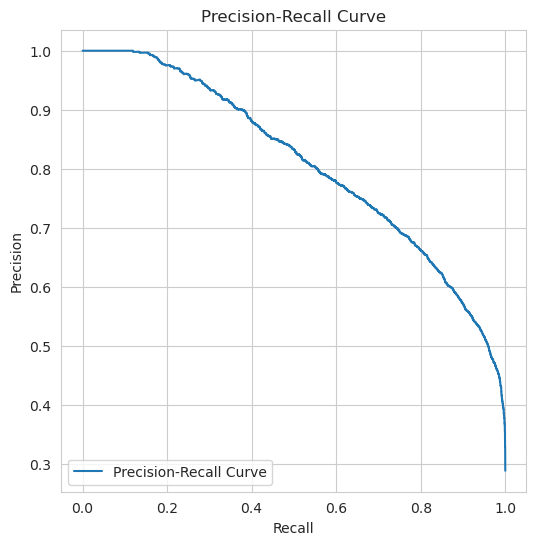

In [ ]:
plot_prec_rec_curve(recall, precision)

In [ ]:
roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])

0.9065598524377617

In [ ]:
fpr, tpr, threshold = roc_curve(y_val, clf.predict_proba(X_val)[:, 1])

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

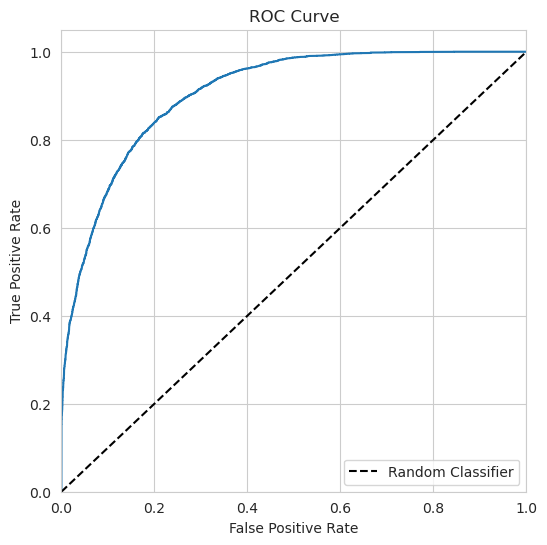

In [ ]:
plot_roc_curve(fpr, tpr)

### LGBM

In [ ]:
def objective(trial):
    params = {
    'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf', 'dart']),
    'num_leaves': trial.suggest_int('num_leaves', 31, 310),
    'max_depth':trial.suggest_int('max_depth', 1, 10),
    "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1),
    "n_estimators": trial.suggest_int('n_estimators', 10, 200),
    "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 100, log=True),
    'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    "subsample": trial.suggest_float('subsample',0., 1.),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    "reg_lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
    "reg_alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
    "objective":'binary'
    # "n_jobs": -1
}
    model = lgbm.LGBMClassifier(**params, early_stopping_rounds=5, verbose=-1)
    model.fit(X_train, y_train,eval_set=[(X_val, y_val)])
    score = f1_score(y_val, model.predict(X_val))
    return score

In [ ]:
lgbm_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
lgbm_study.optimize(objective, n_trials=150)

[I 2024-05-20 20:57:09,183] A new study created in memory with name: no-name-be7dab31-1090-4b68-9e5f-e5b8683f59fa
[I 2024-05-20 20:57:09,562] Trial 0 finished with value: 0.6852536997885835 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'max_depth': 8, 'learning_rate': 0.17202720676170458, 'n_estimators': 178, 'min_child_weight': 2.4658200282262905, 'min_child_samples': 7, 'subsample': 0.042633922939462554, 'colsample_bytree': 0.2687448187419481, 'lambda': 2.776922645470549e-06, 'alpha': 0.0018278343115476767}. Best is trial 0 with value: 0.6852536997885835.
[I 2024-05-20 20:57:09,679] Trial 1 finished with value: 0.6926192031352058 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'max_depth': 6, 'learning_rate': 0.302557651454138, 'n_estimators': 55, 'min_child_weight': 7.871606470882571e-07, 'min_child_samples': 49, 'subsample': 0.8646419014636969, 'colsample_bytree': 0.8402435891884685, 'lambda': 1.7883857146952908e-06, 'alpha': 2.0454714451876327e-07}. Bes

In [ ]:
lgbm_study.best_value

0.7033985581874357

In [ ]:
lgbm_study.best_params

{'boosting_type': 'gbdt',
 'num_leaves': 248,
 'max_depth': 9,
 'learning_rate': 0.11740578566720719,
 'n_estimators': 148,
 'min_child_weight': 2.9325850656253036e-05,
 'min_child_samples': 39,
 'subsample': 0.16127671359154694,
 'colsample_bytree': 0.6550314693047032,
 'lambda': 4.974324754407702e-06,
 'alpha': 5.730693564216386e-07}

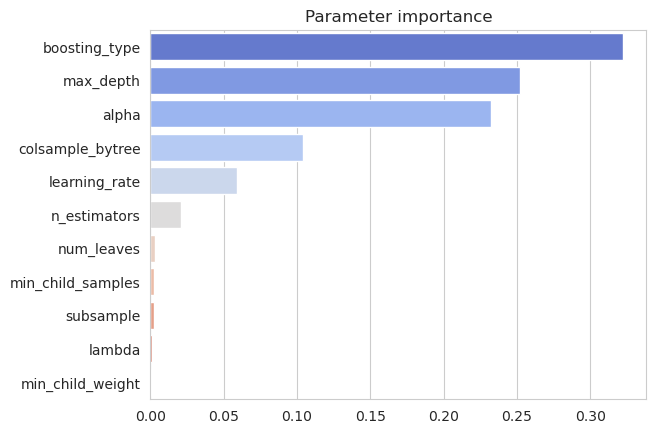

In [ ]:
sns.barplot(optuna.importance.get_param_importances(lgbm_study), orient='h', palette='coolwarm')
plt.title('Parameter importance')
plt.show()

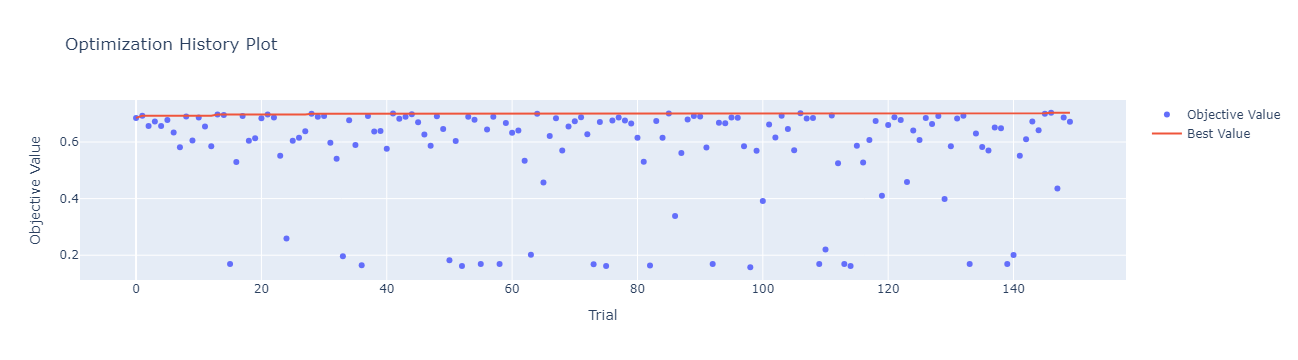

In [ ]:
optuna.visualization.plot_optimization_history(lgbm_study)

In [ ]:
clf2 = lgbm.LGBMClassifier(**lgbm_study.best_params, objective='binary', verbose=-1)

In [ ]:
clf2.fit(X_train, y_train)

LGBMClassifier(alpha=5.730693564216386e-07, colsample_bytree=0.6550314693047032,
               lambda=4.974324754407702e-06, learning_rate=0.11740578566720719,
               max_depth=9, min_child_samples=39,
               min_child_weight=2.9325850656253036e-05, n_estimators=148,
               num_leaves=248, objective='binary',
               subsample=0.16127671359154694, verbose=-1)

In [ ]:
clf2.score(X_val, y_val)

0.8397547551034626

In [ ]:
precision_score(y_val, clf2.predict(X_val))

0.7531645569620253

In [ ]:
recall_score(y_val, clf2.predict(X_val))

0.6611111111111111

In [ ]:
f1_score(y_val, clf2.predict(X_val))

0.7041420118343196

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_val, clf2.predict_proba(X_val)[:, 1])

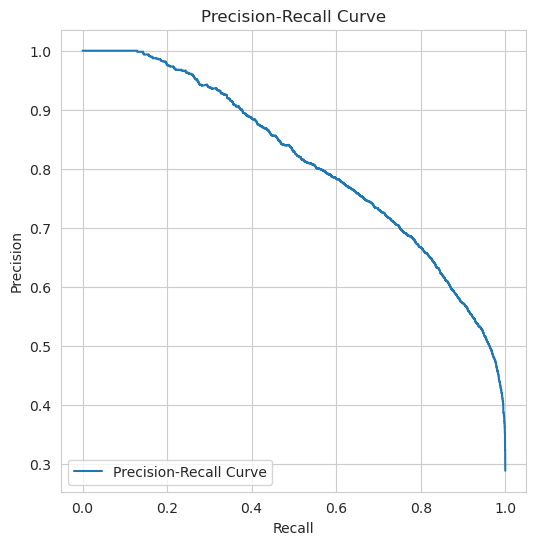

In [ ]:
plot_prec_rec_curve(recall, precision)

In [ ]:
roc_auc_score(y_val, clf2.predict_proba(X_val)[:, 1])

0.9079351953156227

In [ ]:
fpr, tpr, threshold = roc_curve(y_val, clf2.predict_proba(X_val)[:, 1])

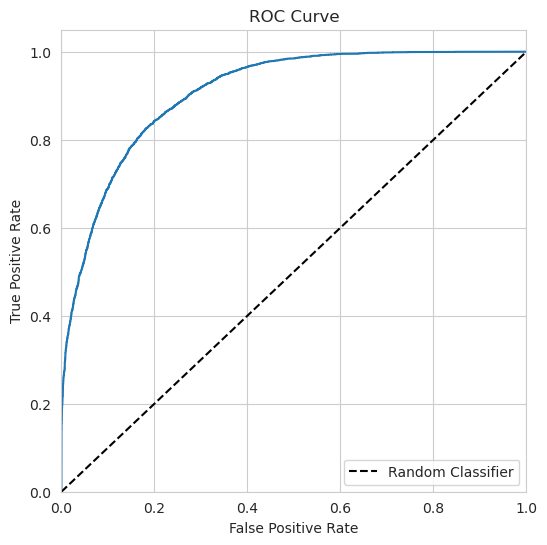

In [ ]:
plot_roc_curve(fpr, tpr)

### Random Forest

In [ ]:
def objective(trial):
    params = {
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 200),
    'max_depth':trial.suggest_int('max_depth', 1, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100),
    "n_estimators": trial.suggest_int('n_estimators', 10, 1000),
    'max_features': trial.suggest_categorical('max_features', ['sqrt','log2']),
    "n_jobs": 8
}
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    score = f1_score(y_val, y_pred=model.predict(X_val))
    return score

In [ ]:
study3 = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
study3.optimize(objective, n_trials=150)

[I 2024-05-20 20:59:42,568] A new study created in memory with name: no-name-bf93e227-4d1f-4938-97ba-b67a1d10d667
[I 2024-05-20 20:59:43,060] Trial 0 finished with value: 0.4225765072384094 and parameters: {'criterion': 'entropy', 'min_samples_split': 23, 'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 168, 'max_features': 'log2'}. Best is trial 0 with value: 0.4225765072384094.
[I 2024-05-20 20:59:44,239] Trial 1 finished with value: 0.5669896938932472 and parameters: {'criterion': 'gini', 'min_samples_split': 21, 'max_depth': 10, 'min_samples_leaf': 85, 'n_estimators': 379, 'max_features': 'log2'}. Best is trial 1 with value: 0.5669896938932472.
[I 2024-05-20 20:59:45,351] Trial 2 finished with value: 0.0 and parameters: {'criterion': 'gini', 'min_samples_split': 145, 'max_depth': 1, 'min_samples_leaf': 81, 'n_estimators': 451, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5669896938932472.
[I 2024-05-20 20:59:45,506] Trial 3 finished with value: 0.19760609357997824 

In [ ]:
study3.best_value

0.6013323464100666

<Axes: >

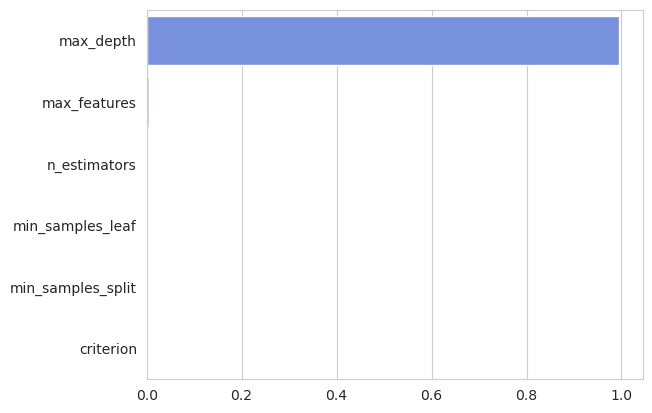

In [ ]:
sns.barplot(optuna.importance.get_param_importances(study3), orient='h', palette='coolwarm')

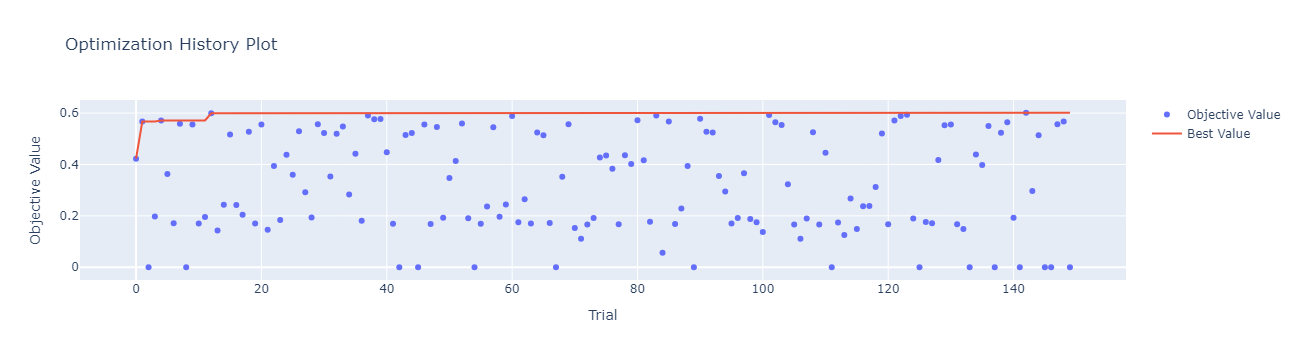

In [ ]:
optuna.visualization.plot_optimization_history(study3)

In [ ]:
study3.best_params

{'criterion': 'gini',
 'min_samples_split': 44,
 'max_depth': 10,
 'min_samples_leaf': 7,
 'n_estimators': 162,
 'max_features': 'sqrt'}

In [ ]:
clf3 = RandomForestClassifier(**study3.best_params)
clf3.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=7, min_samples_split=44,
                       n_estimators=162)

In [ ]:
clf3.score(X_val, y_val)

0.8128614226990873

In [ ]:
precision_score(y_val, clf3.predict(X_val))

0.774132730015083

In [ ]:
recall_score(y_val, clf3.predict(X_val))

0.4958937198067633

In [ ]:
f1_score(y_val, clf3.predict(X_val))

0.6045347467608951

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_val, clf3.predict_proba(X_val)[:, 1])

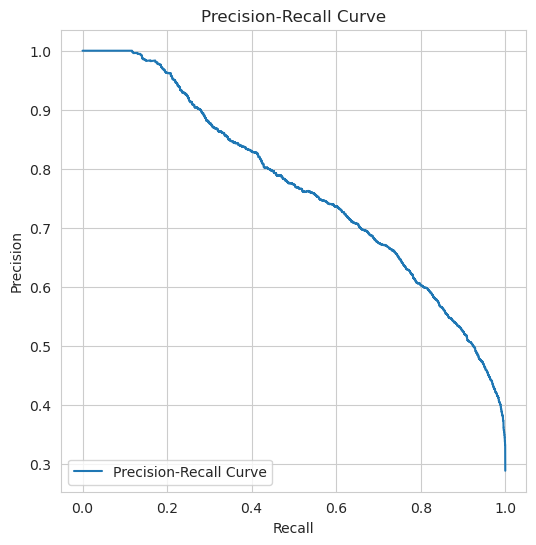

In [ ]:
plot_prec_rec_curve(recall, precision)

In [ ]:
roc_auc_score(y_val, clf3.predict_proba(X_val)[:, 1])

0.8832440987639605

In [ ]:
fpr, tpr, threshold = roc_curve(y_val, clf3.predict_proba(X_val)[:, 1])

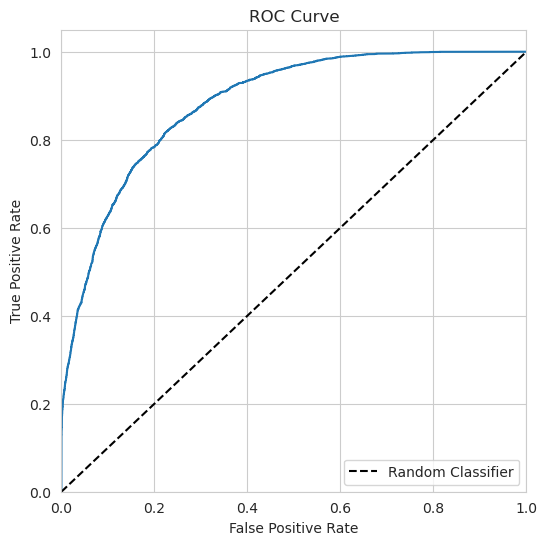

In [ ]:
plot_roc_curve(fpr, tpr)

### Voting Classifier

In [ ]:
vclf = VotingClassifier(estimators=[('xgb', clf), ('lgb', clf2), ('rf', clf3)], weights=[0.4, 0.4, 0.2],voting='soft')

In [ ]:
vclf.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(alpha=3.5955899799065976,
                                            base_score=None, booster='dart',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5714314827569386,
                                            device='cpu',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=2.473557597211264e-06,
                                            grow_policy='depthw...
                                             lambda=4.974324754407702e-06,
                                             learning_rate=0.11740578566720719,
                                             max_depth=9, min_child_samples=39,
                                             min_child_weight=2.9325850656253036e-05,
                                             n_estimators=148, num_leaves=248,
                                             objective='binary',
                                             subsample=0.16127671359154694,
                                             verbose=-1)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=7,
                                                     min_samples_split=44,
                                                     n_estimators=162))],
                 voting='soft', weights=[0.4, 0.4, 0.2])

In [ ]:
vclf.score(X_val, y_val)

0.8403121298683202

In [ ]:
precision_score(y_val, vclf.predict(X_val))

0.7643020594965675

In [ ]:
recall_score(y_val, vclf.predict(X_val))

0.6454106280193237

In [ ]:
f1_score(y_val, vclf.predict(X_val))

0.6998428496595076

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_val, vclf.predict_proba(X_val)[:, 1])

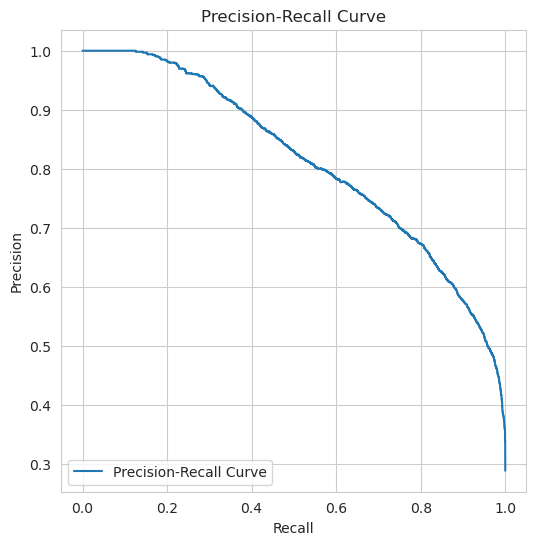

In [ ]:
plot_prec_rec_curve(recall, precision)

In [ ]:
roc_auc_score(y_val, vclf.predict_proba(X_val)[:, 1])

0.9084178259119403

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, vclf.predict_proba(X_val)[:, 1])

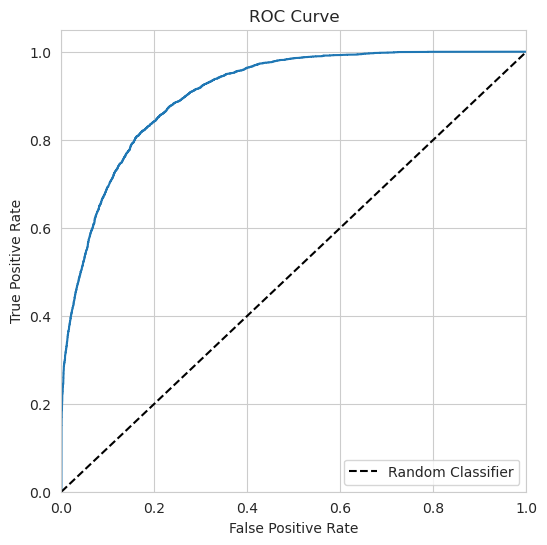

In [ ]:
plot_roc_curve(fpr, tpr)

Avaliação da capacidade de generalização do classificador no set de teste

In [ ]:
acc_test = vclf.score(X_test, y_test)

In [ ]:
prec_test = precision_score(y_test, vclf.predict(X_test))

In [ ]:
rec_test = recall_score(y_test, vclf.predict(X_test))

In [ ]:
f1_test = f1_score(y_test, vclf.predict(X_test))

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, vclf.predict_proba(X_test)[:, 1])

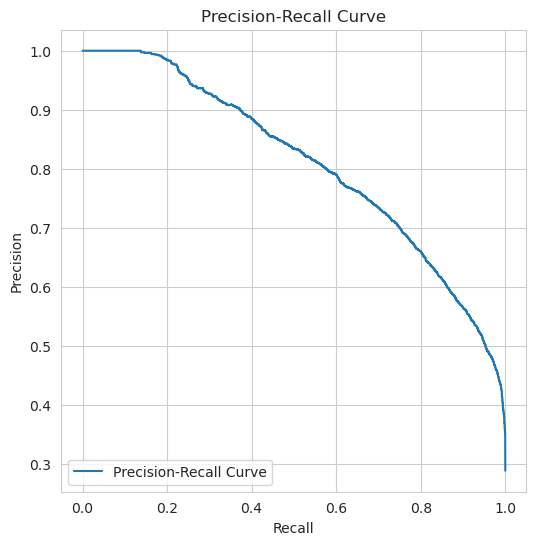

In [ ]:
plot_prec_rec_curve(recall, precision)

In [ ]:
auc_test = roc_auc_score(y_test, vclf.predict_proba(X_test)[:, 1])

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, vclf.predict_proba(X_test)[:, 1])

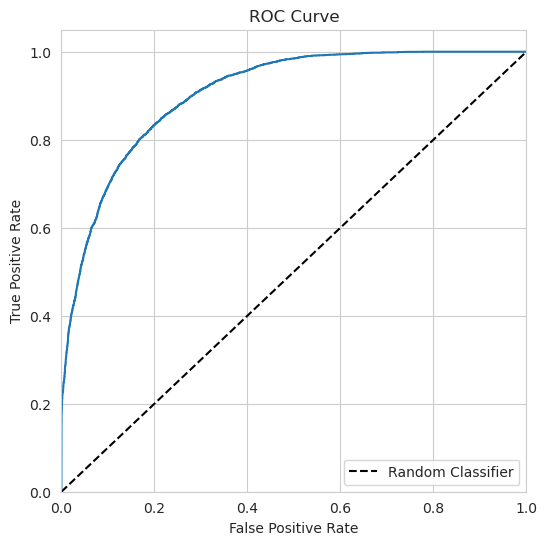

In [ ]:
plot_roc_curve(fpr, tpr)

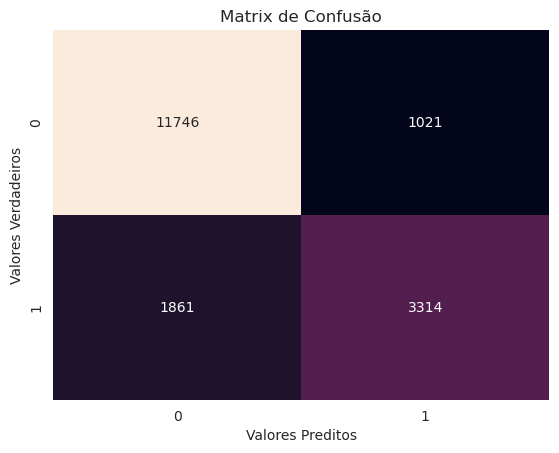

In [ ]:
g = sns.heatmap(confusion_matrix(y_test, vclf.predict(X_test)), annot=True, fmt='.0f', cbar=False)
g.set_xlabel('Valores Preditos')
g.set_ylabel('Valores Verdadeiros')
g.set_title('Matrix de Confusão')
plt.show()

## Avaliação do modelo

In [ ]:
print('Scores do modelo de classificação:\n')
print(f'Acurácia: {acc_test*100:.2f}%')
print(f'Precision: {prec_test:.2f}')
print(f'Recall: {rec_test:.2f}')
print(f'F1: {f1_test:.2f}')
print(f'ROC_AUC: {auc_test:.2f}')

Scores do modelo de classificação:

Acurácia: 83.94%
Precision: 0.76
Recall: 0.64
F1: 0.70
ROC_AUC: 0.91


#### Discussão

- O modelo preditivo de classificação proposto possui uma acurácia de 84%, sendo capaz de classificar corretamente se houve ou não 'cancellation' em 84% dos casos.
- O resultado da métrica 'Precision' demonstra que de todos os cancelamentos previstos pelo modelo, 76% foram confirmados.
- Já o da métrica 'Recall' sugere que de todos os cancelamentos que realmente aconteceram, o modelo detectou 64% deles.
- A métrica F1 representa o balaceamento entre 'Precision' e 'Recall'.
- O resultado de 'ROC_AUC' demonstra que o modelo consegue diferenciar entre casos de cancelamento ou não em 91% das amostras.
- Devido ao desbalanceamento entre as classes de 'cancellation'(0, 1), com a classe '0' possuindo significativamente maior número de exemplos, a acurácia não pode ser a única métrica para avaliação do modelo, uma vez que ela não reflete a capacidade do modelo em detectar a classe menos representativa '1'. Dessa forma, é importante que os resultados das demais métricas sejam adequados. Embora o modelo apresente um valor de 'ROC_AUC' alto, o resultado de 'Recall' demonstra que o modelo não previu 36% dos casos de cancelamento, o que é um problema, já que impede a preparação prévia da administração do hotel para utilizar os quartos das reservas canceladas, levando a possíveis perdas financeiras. Além disso, é possível observar pelos valores das métricas 'F1' e 'Precision' que o modelo está favorecendo classificar corretamente os cancelamentos identificados em detrimento de detectar os cancelamentos verdadeiros.

c) Ao realizar a validação cruzada do modelo de classificação, discuta sobre as diferenças entre
utilizar uma separação entre treino e teste aleatória e uma separação temporal (Ex: treino em
2015 e 2016 e validação em 2017). Os resultados são diferentes? Qual o mais indicado?

- Utilizar uma separação entre treino e teste aleatória pode ser interessante para avaliar a capacidade de generalização do modelo. Contudo, no caso de um modelo de classificação, esse tipo de separação pode provocar um desbalaceamento importante entre os dados de treino e de teste em relação à quantidade de exemplos de cada uma das classes a serem identificadas.
- Em modelos de classificação de séries temporais, utilizar uma separação temporal para validação cruzada é a opção mais indicada pois essa divisão representa cenários reais por utilizar dados do 'passado' para treino e ser avaliado em dados do 'futuro'. Além disso, a separação temporal garante que não haja vazamento de dados ('data leakage') entre os dados de treino e teste, impedindo que o modelo obtenha informações do 'futuro' durante o treino, o que facilitaria suas predições nos dados de teste, porém pioraria sua capacidade de generalização.